In [2]:
import nipype
import os,glob,sys,shutil
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
from IPython.display import Image

In [3]:
subjRootDir = "/data/HCP_Data/HCP_BedpostData/"

FULL_SUBJECT_LIST = [x for x in os.listdir(subjRootDir) if os.path.isdir( subjRootDir+x+'/T1w/Diffusion')]
print(len(FULL_SUBJECT_LIST),"Subjects are potentially available to be processed!")

804 Subjects are potentially available to be processed!


In [ ]:
!ls /data/NipypeScratch/

In [ ]:
### Sample Subject = /HCP_Data/HCP_BedpostData/106016/T1w/Diffusion.bedpostX


In [4]:
subject_id_infosource = pe.Node(util.IdentityInterface(fields=['subject_id']),
                                name='subject_id_infosource')
subject_id_infosource.iterables = ('subject_id', FULL_SUBJECT_LIST)

In [5]:
datasource = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
                                               outfields=['dwi', 'bvec', 'bval']),
                                                 name='datasource')
datasource.inputs.base_directory = subjRootDir 
datasource.inputs.sort_filelist = True
datasource.inputs.template = '%s/T1w/Diffusion/%s'
datasource.inputs.template_args = dict(dwi=[['subject_id', 'data.nii.gz']],
                                       bvecs=[['subject_id', 'bvecs']],
                                       bvals=[['subject_id', 'bvals']],
                                       nodif_brain_mask=[['subject_id','nodif_brain_mask.nii.gz']])
## Just mapped each subject to the corresponding bvec,bvals, brain mask and preprocessed DWI data
### Create the Node for DTIFIT
dtifit = pe.Node(interface=fsl.DTIFit(), name='dtifit')


gen_fa = pe.Workflow(name="gen_fa")
gen_fa.base_dir = '/data/HCP_Data/NipypeScratch/'
gen_fa.connect(subject_id_infosource, 'subject_id', datasource, 'subject_id')

gen_fa.connect(subject_id_infosource, 'subject_id', dtifit, 'base_name')
gen_fa.connect(datasource, 'bvecs', dtifit, 'bvecs')
gen_fa.connect(datasource, 'bvals', dtifit, 'bvals')
gen_fa.connect(datasource, 'nodif_brain_mask', dtifit, 'mask')
gen_fa.connect(datasource, 'dwi', dtifit, 'dwi')

In [6]:
datasink = pe.Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join('/data/HCP_Data/NipypeScratch/',
                                              'dtifit_results')
datasink.inputs.parameterization = False
gen_fa.connect(dtifit, 'FA', datasink, 'FA')
gen_fa.connect(dtifit, 'MD', datasink, 'MD')
gen_fa.connect(dtifit, 'V1', datasink, 'V1')
gen_fa.connect(dtifit, 'V2', datasink, 'V2')
gen_fa.connect(dtifit, 'V3', datasink, 'V3')
gen_fa.connect(dtifit, 'L1', datasink, 'L1')
gen_fa.connect(dtifit, 'L2', datasink, 'L2')
gen_fa.connect(dtifit, 'L3', datasink, 'L3')



# tifit/947668_FA.nii.gz
# ./_subject_id_947668/dtifit/947668_S0.nii.gz
# ./_subject_id_947668/dtifit/947668_MO.nii.gz
# ./_subject_id_947668/dtifit/947668_V1.nii.gz
# ./_subject_id_947668/dtifit/947668_V2.nii.gz
# ./_subject_id_947668/dtifit/947668_V3.nii.gz
# ./_subject_id_947668/dtifit/947668_L1.nii.gz
# ./_subject_id_947668/dtifit/947668_L2.nii.gz
# ./_subject_id_947668/dtifit/947668_L3.nii.gz
# ./_subject_id_947668/dtifit/947668_MD.nii.gz


180811-00:23:07,999 workflow INFO:
	 Generated workflow graph: /data/HCP_Data/NipypeScratch/gen_fa/graph.png (graph2use=colored, simple_form=False).
/data/HCP_Data/NipypeScratch/gen_fa/graph.png


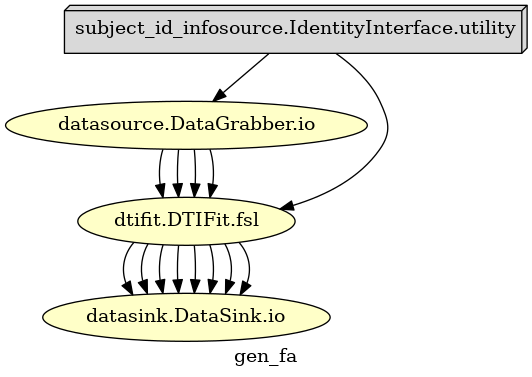

In [7]:
print(gen_fa.write_graph(graph2use='colored',simple_form=False))
Image('/data/HCP_Data/NipypeScratch/gen_fa/graph.png')
#Image('/data/HCP_Data/NipypeScratch/gen_fa/graph.png')

In [ ]:
gen_fa.run(plugin='MultiProc', plugin_args={'n_procs' : 10})


In [ ]:
#!ls /data/HCP_Data/HCP_BedpostData/106016/T1w/Diffusion/

In [ ]:
### Copy files in the dtifit results directory to the canonical location if the file isnt there yet
from os.path import join as oj
import shutil
fileType = ["FA", "L1", "L2", "L3", "MD", "V1", "V2", "V3"]
dtifit_NP_Results = "/data/HCP_Data/NipypeScratch/dtifit_results/"

HCP_procData = "/data/HCP_Data/HCP_BedpostData/"

for ft in fileType:
    ## going to loop through each fileType directory and grab the files and then copy them to the HCP Data directory
    ## if they don't exist 
    fl = os.listdir( oj(dtifit_NP_Results,ft) )
    for f in fl:
        subjID = f.split('_')[0]
        
        targetFile = oj(HCP_procData,subjID,"T1w","Diffusion","data_%s.nii.gz"%ft)
        srcFile = oj(dtifit_NP_Results,ft,f)
        #print(f,subjID,srcFile,targetFile)
        
        if not os.path.isfile(targetFile):
            shutil.copy(srcFile,targetFile)

In [17]:
### Also create the nodif_brain and nodif images for any file that has DTIFIT run

from nipype.caching import Memory
mem = Memory(base_dir='/data/HCP_Data/NipypeScratch/')

fsl_ExtractROI = mem.cache(fsl.ExtractROI)
fsl_ImageMaths = mem.cache(fsl.ImageMaths)


for s in FULL_SUBJECT_LIST:
    dtiData = "/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/data.nii.gz" % s
    nodif_brain_mask = "/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/nodif_brain_mask.nii.gz" % s
    
    
    ### These are the files I am trying to generate...
    nodif_brain =  "/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/nodif_brain.nii.gz" % s
    nodif =  "/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/nodif.nii.gz" % s

    if not os.path.isfile(nodif):
        print(nodif)
        try:
            r = fsl_ExtractROI(in_file=dtiData, t_min=0,t_size=1)
            print(r.outputs.roi_file)
        except:
            print("Subject %s doesn't have all DTI data??" % s)
    
        ## Now copy the generated nodif file to the canonical location
        shutil.copy(r.outputs.roi_file,nodif)
            
            
    if not os.path.isfile(nodif_brain):
        try:
            rim = fsl_ImageMaths(in_file=r.outputs.roi_file, op_string="-mas %s" % nodif_brain_mask)
        except:
            print("Subject %s could not run masking of original file" % s)
        shutil.copy(rim.outputs.out_file,nodif_brain)

        
        

/data/HCP_Data/HCP_BedpostData/100206/T1w/Diffusion/nodif.nii.gz
180812-13:09:53,393 workflow INFO:
	 [Node] Setting-up "7d3856cbdf87df18f56099f5cff75559" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/7d3856cbdf87df18f56099f5cff75559".
180812-13:09:53,397 workflow INFO:
	 [Node] Cached "7d3856cbdf87df18f56099f5cff75559" - collecting precomputed outputs
180812-13:09:53,398 workflow INFO:
	 [Node] "7d3856cbdf87df18f56099f5cff75559" found cached.
/data/HCP_Data/HCP_BedpostData/100307/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/100307/T1w/Diffusion/nodif.nii.gz
180812-13:09:53,439 workflow INFO:
	 [Node] Setting-up "7a2fe3b63aeb8488eb89316c7e250467" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7a2fe3b63aeb8488eb89316c7e250467".
180812-13:09:53,443 workflow INFO:
	 [Node] Cached "7a2fe3b63aeb8488eb89316c7e250467" - collecting precomputed outputs
180812-13:09:53,445 workflow INFO:
	 [Node] "7a2fe3b63aeb8

180812-13:09:54,131 workflow INFO:
	 [Node] Cached "3870235e7ea080d2babda279f9417eef" - collecting precomputed outputs
180812-13:09:54,132 workflow INFO:
	 [Node] "3870235e7ea080d2babda279f9417eef" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3870235e7ea080d2babda279f9417eef/data_roi.nii.gz
180812-13:09:54,180 workflow INFO:
	 [Node] Setting-up "7e40b889c8f5d3e2192468dd1637654b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/7e40b889c8f5d3e2192468dd1637654b".
180812-13:09:54,184 workflow INFO:
	 [Node] Cached "7e40b889c8f5d3e2192468dd1637654b" - collecting precomputed outputs
180812-13:09:54,185 workflow INFO:
	 [Node] "7e40b889c8f5d3e2192468dd1637654b" found cached.
/data/HCP_Data/HCP_BedpostData/123521/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/123521/T1w/Diffusion/nodif.nii.gz
180812-13:09:54,217 workflow INFO:
	 [Node] Setting-up "e540fd229206b0432eb80b7b7588365a" in "/data/HCP_Data/N

180812-13:09:54,860 workflow INFO:
	 [Node] Cached "adb0dcce6d9199c76210f21b9bcd7823" - collecting precomputed outputs
180812-13:09:54,861 workflow INFO:
	 [Node] "adb0dcce6d9199c76210f21b9bcd7823" found cached.
/data/HCP_Data/HCP_BedpostData/133019/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/133019/T1w/Diffusion/nodif.nii.gz
180812-13:09:54,896 workflow INFO:
	 [Node] Setting-up "e4e7975416ce2e9d4ce461788ffc07df" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e4e7975416ce2e9d4ce461788ffc07df".
180812-13:09:54,899 workflow INFO:
	 [Node] Cached "e4e7975416ce2e9d4ce461788ffc07df" - collecting precomputed outputs
180812-13:09:54,900 workflow INFO:
	 [Node] "e4e7975416ce2e9d4ce461788ffc07df" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e4e7975416ce2e9d4ce461788ffc07df/data_roi.nii.gz
180812-13:09:54,953 workflow INFO:
	 [Node] Setting-up "c300510ff5ca9d415954fb9f0699654c" in "/data/HCP_Data/N

180812-13:09:55,566 workflow INFO:
	 [Node] Cached "b4924fa2418abf4bde2f403dc40f056e" - collecting precomputed outputs
180812-13:09:55,567 workflow INFO:
	 [Node] "b4924fa2418abf4bde2f403dc40f056e" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/b4924fa2418abf4bde2f403dc40f056e/data_roi.nii.gz
180812-13:09:55,625 workflow INFO:
	 [Node] Setting-up "2f4a6ef9fc2e378d3f7e5173c2e48e3c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2f4a6ef9fc2e378d3f7e5173c2e48e3c".
180812-13:09:55,629 workflow INFO:
	 [Node] Cached "2f4a6ef9fc2e378d3f7e5173c2e48e3c" - collecting precomputed outputs
180812-13:09:55,630 workflow INFO:
	 [Node] "2f4a6ef9fc2e378d3f7e5173c2e48e3c" found cached.
/data/HCP_Data/HCP_BedpostData/146533/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/146533/T1w/Diffusion/nodif.nii.gz
180812-13:09:55,670 workflow INFO:
	 [Node] Setting-up "8ce0dca3fac2878b05495435233edb16" in "/data/HCP_Data/N

180812-13:09:56,313 workflow INFO:
	 [Node] Cached "8c34ea6bbb7ea927469e5ec4d3dabdfe" - collecting precomputed outputs
180812-13:09:56,314 workflow INFO:
	 [Node] "8c34ea6bbb7ea927469e5ec4d3dabdfe" found cached.
/data/HCP_Data/HCP_BedpostData/150019/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/150019/T1w/Diffusion/nodif.nii.gz
180812-13:09:56,350 workflow INFO:
	 [Node] Setting-up "07869f44276fc4f4fe211b4c323398cf" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/07869f44276fc4f4fe211b4c323398cf".
180812-13:09:56,353 workflow INFO:
	 [Node] Cached "07869f44276fc4f4fe211b4c323398cf" - collecting precomputed outputs
180812-13:09:56,354 workflow INFO:
	 [Node] "07869f44276fc4f4fe211b4c323398cf" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/07869f44276fc4f4fe211b4c323398cf/data_roi.nii.gz
180812-13:09:56,409 workflow INFO:
	 [Node] Setting-up "cacd78a816dbfe97192964e2521176f7" in "/data/HCP_Data/N

180812-13:09:57,37 workflow INFO:
	 [Node] Cached "0ef3775ef5cb043a8ccca459afdf75a2" - collecting precomputed outputs
180812-13:09:57,38 workflow INFO:
	 [Node] "0ef3775ef5cb043a8ccca459afdf75a2" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0ef3775ef5cb043a8ccca459afdf75a2/data_roi.nii.gz
180812-13:09:57,85 workflow INFO:
	 [Node] Setting-up "a3ca77591d5a74880419a3b9dad42fb2" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/a3ca77591d5a74880419a3b9dad42fb2".
180812-13:09:57,89 workflow INFO:
	 [Node] Cached "a3ca77591d5a74880419a3b9dad42fb2" - collecting precomputed outputs
180812-13:09:57,90 workflow INFO:
	 [Node] "a3ca77591d5a74880419a3b9dad42fb2" found cached.
/data/HCP_Data/HCP_BedpostData/154734/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/154734/T1w/Diffusion/nodif.nii.gz
180812-13:09:57,122 workflow INFO:
	 [Node] Setting-up "f86999bd76734e0d28c57e27765282f7" in "/data/HCP_Data/Nipype

180812-13:09:57,749 workflow INFO:
	 [Node] Cached "379424338d819585bcd2bc5de0eb4af4" - collecting precomputed outputs
180812-13:09:57,750 workflow INFO:
	 [Node] "379424338d819585bcd2bc5de0eb4af4" found cached.
/data/HCP_Data/HCP_BedpostData/159340/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/159340/T1w/Diffusion/nodif.nii.gz
180812-13:09:57,789 workflow INFO:
	 [Node] Setting-up "97b990eae300c370b3f1c3c68ac717f1" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/97b990eae300c370b3f1c3c68ac717f1".
180812-13:09:57,793 workflow INFO:
	 [Node] Cached "97b990eae300c370b3f1c3c68ac717f1" - collecting precomputed outputs
180812-13:09:57,794 workflow INFO:
	 [Node] "97b990eae300c370b3f1c3c68ac717f1" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/97b990eae300c370b3f1c3c68ac717f1/data_roi.nii.gz
180812-13:09:57,846 workflow INFO:
	 [Node] Setting-up "87b6075e341459efcc6358f60c3fce47" in "/data/HCP_Data/N

180812-13:09:58,472 workflow INFO:
	 [Node] Cached "0b46b4dbc83da4b681d34849405cf05f" - collecting precomputed outputs
180812-13:09:58,472 workflow INFO:
	 [Node] "0b46b4dbc83da4b681d34849405cf05f" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0b46b4dbc83da4b681d34849405cf05f/data_roi.nii.gz
180812-13:09:58,522 workflow INFO:
	 [Node] Setting-up "95ebfeb1d3f3143ee735ef0c84710ff8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/95ebfeb1d3f3143ee735ef0c84710ff8".
180812-13:09:58,526 workflow INFO:
	 [Node] Cached "95ebfeb1d3f3143ee735ef0c84710ff8" - collecting precomputed outputs
180812-13:09:58,527 workflow INFO:
	 [Node] "95ebfeb1d3f3143ee735ef0c84710ff8" found cached.
/data/HCP_Data/HCP_BedpostData/169747/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/169747/T1w/Diffusion/nodif.nii.gz
180812-13:09:58,561 workflow INFO:
	 [Node] Setting-up "e7c1a46215640654cf41f0085882e8fc" in "/data/HCP_Data/N

180812-13:09:59,200 workflow INFO:
	 [Node] Cached "481010854f26055fafc9f8d85dbbf412" - collecting precomputed outputs
180812-13:09:59,201 workflow INFO:
	 [Node] "481010854f26055fafc9f8d85dbbf412" found cached.
/data/HCP_Data/HCP_BedpostData/175338/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/175338/T1w/Diffusion/nodif.nii.gz
180812-13:09:59,233 workflow INFO:
	 [Node] Setting-up "a34a4ad932234277994b28cea8c9cccc" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a34a4ad932234277994b28cea8c9cccc".
180812-13:09:59,237 workflow INFO:
	 [Node] Cached "a34a4ad932234277994b28cea8c9cccc" - collecting precomputed outputs
180812-13:09:59,237 workflow INFO:
	 [Node] "a34a4ad932234277994b28cea8c9cccc" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a34a4ad932234277994b28cea8c9cccc/data_roi.nii.gz
180812-13:09:59,289 workflow INFO:
	 [Node] Setting-up "58e96c9a741583580de22086c1bf0211" in "/data/HCP_Data/N

180812-13:09:59,886 workflow INFO:
	 [Node] Cached "7397ec71db63a720070ca0e3bfcd95f1" - collecting precomputed outputs
180812-13:09:59,887 workflow INFO:
	 [Node] "7397ec71db63a720070ca0e3bfcd95f1" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7397ec71db63a720070ca0e3bfcd95f1/data_roi.nii.gz
180812-13:09:59,936 workflow INFO:
	 [Node] Setting-up "eb88e4963db480887ec4aa7f7682ab1d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/eb88e4963db480887ec4aa7f7682ab1d".
180812-13:09:59,939 workflow INFO:
	 [Node] Cached "eb88e4963db480887ec4aa7f7682ab1d" - collecting precomputed outputs
180812-13:09:59,940 workflow INFO:
	 [Node] "eb88e4963db480887ec4aa7f7682ab1d" found cached.
/data/HCP_Data/HCP_BedpostData/182840/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/182840/T1w/Diffusion/nodif.nii.gz
180812-13:09:59,973 workflow INFO:
	 [Node] Setting-up "f5654c5749447f56690881033d2c3150" in "/data/HCP_Data/N

180812-13:10:00,709 workflow INFO:
	 [Node] Cached "2e356661e4f74606e411f22c24520981" - collecting precomputed outputs
180812-13:10:00,710 workflow INFO:
	 [Node] "2e356661e4f74606e411f22c24520981" found cached.
/data/HCP_Data/HCP_BedpostData/191437/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/191437/T1w/Diffusion/nodif.nii.gz
180812-13:10:00,749 workflow INFO:
	 [Node] Setting-up "31c672eba59a8c016164ff3d35c89147" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/31c672eba59a8c016164ff3d35c89147".
180812-13:10:00,755 workflow INFO:
	 [Node] Cached "31c672eba59a8c016164ff3d35c89147" - collecting precomputed outputs
180812-13:10:00,757 workflow INFO:
	 [Node] "31c672eba59a8c016164ff3d35c89147" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/31c672eba59a8c016164ff3d35c89147/data_roi.nii.gz
180812-13:10:00,809 workflow INFO:
	 [Node] Setting-up "f3acab24cdaed6f682bd143ed6e24a8d" in "/data/HCP_Data/N

180812-13:10:01,442 workflow INFO:
	 [Node] Cached "32dee6e95cb3bfc335cc6cb289fa9d90" - collecting precomputed outputs
180812-13:10:01,443 workflow INFO:
	 [Node] "32dee6e95cb3bfc335cc6cb289fa9d90" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/32dee6e95cb3bfc335cc6cb289fa9d90/data_roi.nii.gz
180812-13:10:01,494 workflow INFO:
	 [Node] Setting-up "b389c7746342a2385d0d9ea15c50164d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/b389c7746342a2385d0d9ea15c50164d".
180812-13:10:01,498 workflow INFO:
	 [Node] Cached "b389c7746342a2385d0d9ea15c50164d" - collecting precomputed outputs
180812-13:10:01,499 workflow INFO:
	 [Node] "b389c7746342a2385d0d9ea15c50164d" found cached.
/data/HCP_Data/HCP_BedpostData/204319/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/204319/T1w/Diffusion/nodif.nii.gz
180812-13:10:01,545 workflow INFO:
	 [Node] Setting-up "19b3acba4e5f65167c2352dffd9bdcaa" in "/data/HCP_Data/N

180812-13:10:02,199 workflow INFO:
	 [Node] Cached "e38e431d7c8c1f95588aae51d2a166a1" - collecting precomputed outputs
180812-13:10:02,199 workflow INFO:
	 [Node] "e38e431d7c8c1f95588aae51d2a166a1" found cached.
/data/HCP_Data/HCP_BedpostData/211316/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/211316/T1w/Diffusion/nodif.nii.gz
180812-13:10:02,235 workflow INFO:
	 [Node] Setting-up "df837c78c9a50d5a1c314af11970890a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/df837c78c9a50d5a1c314af11970890a".
180812-13:10:02,239 workflow INFO:
	 [Node] Cached "df837c78c9a50d5a1c314af11970890a" - collecting precomputed outputs
180812-13:10:02,240 workflow INFO:
	 [Node] "df837c78c9a50d5a1c314af11970890a" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/df837c78c9a50d5a1c314af11970890a/data_roi.nii.gz
180812-13:10:02,284 workflow INFO:
	 [Node] Setting-up "9aa00ee55076c00601d0f50b701deca3" in "/data/HCP_Data/N

180812-13:10:02,895 workflow INFO:
	 [Node] Cached "fa9182540e1198b8ba87abde540f8f15" - collecting precomputed outputs
180812-13:10:02,896 workflow INFO:
	 [Node] "fa9182540e1198b8ba87abde540f8f15" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/fa9182540e1198b8ba87abde540f8f15/data_roi.nii.gz
180812-13:10:02,943 workflow INFO:
	 [Node] Setting-up "adf1496bd6d9fae3d47e19c2296f6a12" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/adf1496bd6d9fae3d47e19c2296f6a12".
180812-13:10:02,947 workflow INFO:
	 [Node] Cached "adf1496bd6d9fae3d47e19c2296f6a12" - collecting precomputed outputs
180812-13:10:02,948 workflow INFO:
	 [Node] "adf1496bd6d9fae3d47e19c2296f6a12" found cached.
/data/HCP_Data/HCP_BedpostData/237334/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/237334/T1w/Diffusion/nodif.nii.gz
180812-13:10:02,980 workflow INFO:
	 [Node] Setting-up "326aca9ee6f57ea448090fb6f3524b24" in "/data/HCP_Data/N

180812-13:10:03,603 workflow INFO:
	 [Node] Cached "03a80968465163664e3af137d6c40896" - collecting precomputed outputs
180812-13:10:03,604 workflow INFO:
	 [Node] "03a80968465163664e3af137d6c40896" found cached.
/data/HCP_Data/HCP_BedpostData/303119/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/303119/T1w/Diffusion/nodif.nii.gz
180812-13:10:03,634 workflow INFO:
	 [Node] Setting-up "06d4ef5df19878fd783d1656d675548d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/06d4ef5df19878fd783d1656d675548d".
180812-13:10:03,638 workflow INFO:
	 [Node] Cached "06d4ef5df19878fd783d1656d675548d" - collecting precomputed outputs
180812-13:10:03,639 workflow INFO:
	 [Node] "06d4ef5df19878fd783d1656d675548d" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/06d4ef5df19878fd783d1656d675548d/data_roi.nii.gz
180812-13:10:03,689 workflow INFO:
	 [Node] Setting-up "c0f89044a06cf3c70a0eaf0e05549c31" in "/data/HCP_Data/N

180812-13:10:04,308 workflow INFO:
	 [Node] Cached "253313cdf9be7874d2a2db46c6df217f" - collecting precomputed outputs
180812-13:10:04,309 workflow INFO:
	 [Node] "253313cdf9be7874d2a2db46c6df217f" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/253313cdf9be7874d2a2db46c6df217f/data_roi.nii.gz
180812-13:10:04,359 workflow INFO:
	 [Node] Setting-up "1988409a82d365083d8f4f6b88c7bf32" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/1988409a82d365083d8f4f6b88c7bf32".
180812-13:10:04,363 workflow INFO:
	 [Node] Cached "1988409a82d365083d8f4f6b88c7bf32" - collecting precomputed outputs
180812-13:10:04,364 workflow INFO:
	 [Node] "1988409a82d365083d8f4f6b88c7bf32" found cached.
/data/HCP_Data/HCP_BedpostData/322224/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/322224/T1w/Diffusion/nodif.nii.gz
180812-13:10:04,399 workflow INFO:
	 [Node] Setting-up "8d2228bf070015e852d7ddfdb3ff1c87" in "/data/HCP_Data/N

180812-13:10:05,30 workflow INFO:
	 [Node] Cached "cb195bc05fb4431965bd06645d9b2765" - collecting precomputed outputs
180812-13:10:05,31 workflow INFO:
	 [Node] "cb195bc05fb4431965bd06645d9b2765" found cached.
/data/HCP_Data/HCP_BedpostData/361234/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/361234/T1w/Diffusion/nodif.nii.gz
180812-13:10:05,65 workflow INFO:
	 [Node] Setting-up "4156ca63531ca65b4e56afbebad64c6c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4156ca63531ca65b4e56afbebad64c6c".
180812-13:10:05,68 workflow INFO:
	 [Node] Cached "4156ca63531ca65b4e56afbebad64c6c" - collecting precomputed outputs
180812-13:10:05,69 workflow INFO:
	 [Node] "4156ca63531ca65b4e56afbebad64c6c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4156ca63531ca65b4e56afbebad64c6c/data_roi.nii.gz
180812-13:10:05,119 workflow INFO:
	 [Node] Setting-up "63aec1cf81abb1a65c4e1c24b2b64406" in "/data/HCP_Data/Nipype

180812-13:10:05,733 workflow INFO:
	 [Node] Cached "e1235586a05eaf76f174f6d7989bc9e1" - collecting precomputed outputs
180812-13:10:05,733 workflow INFO:
	 [Node] "e1235586a05eaf76f174f6d7989bc9e1" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e1235586a05eaf76f174f6d7989bc9e1/data_roi.nii.gz
180812-13:10:05,786 workflow INFO:
	 [Node] Setting-up "80ad68dd184a56d5f34d5ac74271e340" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/80ad68dd184a56d5f34d5ac74271e340".
180812-13:10:05,790 workflow INFO:
	 [Node] Cached "80ad68dd184a56d5f34d5ac74271e340" - collecting precomputed outputs
180812-13:10:05,791 workflow INFO:
	 [Node] "80ad68dd184a56d5f34d5ac74271e340" found cached.
/data/HCP_Data/HCP_BedpostData/406432/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/406432/T1w/Diffusion/nodif.nii.gz
180812-13:10:05,828 workflow INFO:
	 [Node] Setting-up "86128ecc2d4645d6a131f5d02007a55f" in "/data/HCP_Data/N

180812-13:10:06,488 workflow INFO:
	 [Node] Cached "e38d4ba62e4cbf94e52e622f12f39ee6" - collecting precomputed outputs
180812-13:10:06,489 workflow INFO:
	 [Node] "e38d4ba62e4cbf94e52e622f12f39ee6" found cached.
/data/HCP_Data/HCP_BedpostData/555651/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/555651/T1w/Diffusion/nodif.nii.gz
180812-13:10:06,521 workflow INFO:
	 [Node] Setting-up "a306d7912998658eeef42d9fb2777119" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a306d7912998658eeef42d9fb2777119".
180812-13:10:06,524 workflow INFO:
	 [Node] Cached "a306d7912998658eeef42d9fb2777119" - collecting precomputed outputs
180812-13:10:06,525 workflow INFO:
	 [Node] "a306d7912998658eeef42d9fb2777119" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a306d7912998658eeef42d9fb2777119/data_roi.nii.gz
180812-13:10:06,573 workflow INFO:
	 [Node] Setting-up "a9953617d9d20f0eb0e0a04bcedccadd" in "/data/HCP_Data/N

180812-13:10:07,222 workflow INFO:
	 [Node] Cached "b73ccb1f179a3d394b99f956f61b19c7" - collecting precomputed outputs
180812-13:10:07,223 workflow INFO:
	 [Node] "b73ccb1f179a3d394b99f956f61b19c7" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/b73ccb1f179a3d394b99f956f61b19c7/data_roi.nii.gz
180812-13:10:07,278 workflow INFO:
	 [Node] Setting-up "2347c1c92330c740143ae2861c1301af" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2347c1c92330c740143ae2861c1301af".
180812-13:10:07,283 workflow INFO:
	 [Node] Cached "2347c1c92330c740143ae2861c1301af" - collecting precomputed outputs
180812-13:10:07,284 workflow INFO:
	 [Node] "2347c1c92330c740143ae2861c1301af" found cached.
/data/HCP_Data/HCP_BedpostData/647858/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/647858/T1w/Diffusion/nodif.nii.gz
180812-13:10:07,323 workflow INFO:
	 [Node] Setting-up "9f225669529c902794ee43a6719b4a59" in "/data/HCP_Data/N

180812-13:10:08,5 workflow INFO:
	 [Node] Cached "fdacdb74f5595b17efb479d921d65caf" - collecting precomputed outputs
180812-13:10:08,6 workflow INFO:
	 [Node] "fdacdb74f5595b17efb479d921d65caf" found cached.
/data/HCP_Data/HCP_BedpostData/680250/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/680250/T1w/Diffusion/nodif.nii.gz
180812-13:10:08,39 workflow INFO:
	 [Node] Setting-up "6dfcf5b34bb80cc9a09e9f91570bcbf4" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/6dfcf5b34bb80cc9a09e9f91570bcbf4".
180812-13:10:08,42 workflow INFO:
	 [Node] Cached "6dfcf5b34bb80cc9a09e9f91570bcbf4" - collecting precomputed outputs
180812-13:10:08,43 workflow INFO:
	 [Node] "6dfcf5b34bb80cc9a09e9f91570bcbf4" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/6dfcf5b34bb80cc9a09e9f91570bcbf4/data_roi.nii.gz
180812-13:10:08,91 workflow INFO:
	 [Node] Setting-up "e1fb40f806ef327fc27fa9e65d705f19" in "/data/HCP_Data/NipypeScr

180812-13:10:08,701 workflow INFO:
	 [Node] Cached "f64706ebb789ad85c3628a437d503669" - collecting precomputed outputs
180812-13:10:08,703 workflow INFO:
	 [Node] "f64706ebb789ad85c3628a437d503669" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f64706ebb789ad85c3628a437d503669/data_roi.nii.gz
180812-13:10:08,759 workflow INFO:
	 [Node] Setting-up "6472cf2a6e80d268a53873f3c6a01930" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/6472cf2a6e80d268a53873f3c6a01930".
180812-13:10:08,764 workflow INFO:
	 [Node] Cached "6472cf2a6e80d268a53873f3c6a01930" - collecting precomputed outputs
180812-13:10:08,765 workflow INFO:
	 [Node] "6472cf2a6e80d268a53873f3c6a01930" found cached.
/data/HCP_Data/HCP_BedpostData/724446/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/724446/T1w/Diffusion/nodif.nii.gz
180812-13:10:08,804 workflow INFO:
	 [Node] Setting-up "4fafcf884739aa7ce0e6695a540fd0c3" in "/data/HCP_Data/N

180812-13:10:09,536 workflow INFO:
	 [Node] Cached "c9e8f5df21d2be5912a94b28c10bd9f7" - collecting precomputed outputs
180812-13:10:09,537 workflow INFO:
	 [Node] "c9e8f5df21d2be5912a94b28c10bd9f7" found cached.
/data/HCP_Data/HCP_BedpostData/753251/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/753251/T1w/Diffusion/nodif.nii.gz
180812-13:10:09,577 workflow INFO:
	 [Node] Setting-up "51cd66b270a37193948d372da459c32b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/51cd66b270a37193948d372da459c32b".
180812-13:10:09,583 workflow INFO:
	 [Node] Cached "51cd66b270a37193948d372da459c32b" - collecting precomputed outputs
180812-13:10:09,584 workflow INFO:
	 [Node] "51cd66b270a37193948d372da459c32b" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/51cd66b270a37193948d372da459c32b/data_roi.nii.gz
180812-13:10:09,648 workflow INFO:
	 [Node] Setting-up "aa35e36212c670699c917a116d8def4e" in "/data/HCP_Data/N

180812-13:10:10,359 workflow INFO:
	 [Node] Cached "d010859fc893d16ee299b03fc4f670e7" - collecting precomputed outputs
180812-13:10:10,361 workflow INFO:
	 [Node] "d010859fc893d16ee299b03fc4f670e7" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/d010859fc893d16ee299b03fc4f670e7/data_roi.nii.gz
180812-13:10:10,414 workflow INFO:
	 [Node] Setting-up "015f83856d92f0467c6717c29fe5fb22" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/015f83856d92f0467c6717c29fe5fb22".
180812-13:10:10,420 workflow INFO:
	 [Node] Cached "015f83856d92f0467c6717c29fe5fb22" - collecting precomputed outputs
180812-13:10:10,421 workflow INFO:
	 [Node] "015f83856d92f0467c6717c29fe5fb22" found cached.
/data/HCP_Data/HCP_BedpostData/856463/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/856463/T1w/Diffusion/nodif.nii.gz
180812-13:10:10,459 workflow INFO:
	 [Node] Setting-up "03999ada9b159af336003d572f8bca21" in "/data/HCP_Data/N

180812-13:10:11,325 workflow INFO:
	 [Node] Cached "91bf4ff17ee97568585a244c78d7c166" - collecting precomputed outputs
180812-13:10:11,326 workflow INFO:
	 [Node] "91bf4ff17ee97568585a244c78d7c166" found cached.
/data/HCP_Data/HCP_BedpostData/891667/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/891667/T1w/Diffusion/nodif.nii.gz
180812-13:10:11,361 workflow INFO:
	 [Node] Setting-up "d0188652a18b2f9b7c492399a434d204" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/d0188652a18b2f9b7c492399a434d204".
180812-13:10:11,364 workflow INFO:
	 [Node] Cached "d0188652a18b2f9b7c492399a434d204" - collecting precomputed outputs
180812-13:10:11,365 workflow INFO:
	 [Node] "d0188652a18b2f9b7c492399a434d204" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/d0188652a18b2f9b7c492399a434d204/data_roi.nii.gz
180812-13:10:11,416 workflow INFO:
	 [Node] Setting-up "c5a7835ec5f0e876ddfb532d138539d7" in "/data/HCP_Data/N

180812-13:10:12,43 workflow INFO:
	 [Node] Cached "2c6fa4d8cd630d3534b98e8c0716dd95" - collecting precomputed outputs
180812-13:10:12,44 workflow INFO:
	 [Node] "2c6fa4d8cd630d3534b98e8c0716dd95" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2c6fa4d8cd630d3534b98e8c0716dd95/data_roi.nii.gz
180812-13:10:12,92 workflow INFO:
	 [Node] Setting-up "0c945fea457512457487673b570bb589" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/0c945fea457512457487673b570bb589".
180812-13:10:12,96 workflow INFO:
	 [Node] Cached "0c945fea457512457487673b570bb589" - collecting precomputed outputs
180812-13:10:12,97 workflow INFO:
	 [Node] "0c945fea457512457487673b570bb589" found cached.
/data/HCP_Data/HCP_BedpostData/987983/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/987983/T1w/Diffusion/nodif.nii.gz
180812-13:10:12,129 workflow INFO:
	 [Node] Setting-up "2cbfe27e4de5a3838eb52f2f29c85512" in "/data/HCP_Data/Nipype

180812-13:10:13,176 workflow INFO:
	 [Node] Cached "a2181965aea57cd2a94b5aa275415d3a" - collecting precomputed outputs
180812-13:10:13,177 workflow INFO:
	 [Node] "a2181965aea57cd2a94b5aa275415d3a" found cached.
/data/HCP_Data/HCP_BedpostData/143426/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/143426/T1w/Diffusion/nodif.nii.gz
180812-13:10:13,209 workflow INFO:
	 [Node] Setting-up "820a7af852c911a92f119971563c258a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/820a7af852c911a92f119971563c258a".
180812-13:10:13,213 workflow INFO:
	 [Node] Cached "820a7af852c911a92f119971563c258a" - collecting precomputed outputs
180812-13:10:13,214 workflow INFO:
	 [Node] "820a7af852c911a92f119971563c258a" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/820a7af852c911a92f119971563c258a/data_roi.nii.gz
180812-13:10:13,273 workflow INFO:
	 [Node] Setting-up "0be53ac31903784bc99a0418f3b676dd" in "/data/HCP_Data/N

180812-13:10:17,471 workflow INFO:
	 [Node] Cached "f56a64696520c723a7e130c07b157e85" - collecting precomputed outputs
180812-13:10:17,472 workflow INFO:
	 [Node] "f56a64696520c723a7e130c07b157e85" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f56a64696520c723a7e130c07b157e85/data_roi.nii.gz
180812-13:10:17,607 workflow INFO:
	 [Node] Setting-up "8ef88205365b0fa787268a8c3851acab" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8ef88205365b0fa787268a8c3851acab".
180812-13:10:17,611 workflow INFO:
	 [Node] Cached "8ef88205365b0fa787268a8c3851acab" - collecting precomputed outputs
180812-13:10:17,612 workflow INFO:
	 [Node] "8ef88205365b0fa787268a8c3851acab" found cached.
/data/HCP_Data/HCP_BedpostData/162935/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/162935/T1w/Diffusion/nodif.nii.gz
180812-13:10:17,644 workflow INFO:
	 [Node] Setting-up "b5df24cfa4c2bf512324adeac3ff03cc" in "/data/HCP_Data/N

180812-13:10:18,258 workflow INFO:
	 [Node] Cached "9d0d24ffbad029c059428d9b98751a08" - collecting precomputed outputs
180812-13:10:18,259 workflow INFO:
	 [Node] "9d0d24ffbad029c059428d9b98751a08" found cached.
/data/HCP_Data/HCP_BedpostData/139839/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/139839/T1w/Diffusion/nodif.nii.gz
180812-13:10:18,297 workflow INFO:
	 [Node] Setting-up "a8f50324f1b8550246dba1a8e8966f21" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a8f50324f1b8550246dba1a8e8966f21".
180812-13:10:18,301 workflow INFO:
	 [Node] Cached "a8f50324f1b8550246dba1a8e8966f21" - collecting precomputed outputs
180812-13:10:18,302 workflow INFO:
	 [Node] "a8f50324f1b8550246dba1a8e8966f21" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a8f50324f1b8550246dba1a8e8966f21/data_roi.nii.gz
180812-13:10:18,358 workflow INFO:
	 [Node] Setting-up "3f77432b32e99f27011c856342ab75f1" in "/data/HCP_Data/N

180812-13:10:18,974 workflow INFO:
	 [Node] Cached "7d0b0e5e51b5ec6e93baa277a922c76d" - collecting precomputed outputs
180812-13:10:18,975 workflow INFO:
	 [Node] "7d0b0e5e51b5ec6e93baa277a922c76d" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7d0b0e5e51b5ec6e93baa277a922c76d/data_roi.nii.gz
180812-13:10:19,29 workflow INFO:
	 [Node] Setting-up "db38188996140c054b548907955c467c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/db38188996140c054b548907955c467c".
180812-13:10:19,32 workflow INFO:
	 [Node] Cached "db38188996140c054b548907955c467c" - collecting precomputed outputs
180812-13:10:19,33 workflow INFO:
	 [Node] "db38188996140c054b548907955c467c" found cached.
/data/HCP_Data/HCP_BedpostData/162733/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/162733/T1w/Diffusion/nodif.nii.gz
180812-13:10:19,70 workflow INFO:
	 [Node] Setting-up "3583118807be1a163d6a942d2589a17b" in "/data/HCP_Data/Nipyp

180812-13:10:19,700 workflow INFO:
	 [Node] Cached "6a2e66057ef12492df48f2a3a92ab50a" - collecting precomputed outputs
180812-13:10:19,701 workflow INFO:
	 [Node] "6a2e66057ef12492df48f2a3a92ab50a" found cached.
/data/HCP_Data/HCP_BedpostData/132017/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/132017/T1w/Diffusion/nodif.nii.gz
180812-13:10:19,735 workflow INFO:
	 [Node] Setting-up "4334bd323647f8fb6b602aaf79c35b72" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4334bd323647f8fb6b602aaf79c35b72".
180812-13:10:19,738 workflow INFO:
	 [Node] Cached "4334bd323647f8fb6b602aaf79c35b72" - collecting precomputed outputs
180812-13:10:19,739 workflow INFO:
	 [Node] "4334bd323647f8fb6b602aaf79c35b72" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4334bd323647f8fb6b602aaf79c35b72/data_roi.nii.gz
180812-13:10:19,788 workflow INFO:
	 [Node] Setting-up "dd609421b0963f16235f229fb2d0cea9" in "/data/HCP_Data/N

180812-13:10:20,388 workflow INFO:
	 [Node] Cached "24edb305fdbf58db5ac3917eb995c6d1" - collecting precomputed outputs
180812-13:10:20,389 workflow INFO:
	 [Node] "24edb305fdbf58db5ac3917eb995c6d1" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/24edb305fdbf58db5ac3917eb995c6d1/data_roi.nii.gz
180812-13:10:20,439 workflow INFO:
	 [Node] Setting-up "2b452e8c508e5eeb23f68941ca195a29" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2b452e8c508e5eeb23f68941ca195a29".
180812-13:10:20,443 workflow INFO:
	 [Node] Cached "2b452e8c508e5eeb23f68941ca195a29" - collecting precomputed outputs
180812-13:10:20,444 workflow INFO:
	 [Node] "2b452e8c508e5eeb23f68941ca195a29" found cached.
/data/HCP_Data/HCP_BedpostData/153025/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/153025/T1w/Diffusion/nodif.nii.gz
180812-13:10:20,478 workflow INFO:
	 [Node] Setting-up "c438ec5e1d4765720d22fefe133c15e9" in "/data/HCP_Data/N

180812-13:10:21,143 workflow INFO:
	 [Node] Cached "7222025135e60abab45acfdf71663d1d" - collecting precomputed outputs
180812-13:10:21,144 workflow INFO:
	 [Node] "7222025135e60abab45acfdf71663d1d" found cached.
/data/HCP_Data/HCP_BedpostData/155231/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/155231/T1w/Diffusion/nodif.nii.gz
180812-13:10:21,184 workflow INFO:
	 [Node] Setting-up "8612713d40d22d2e60919a2e58e98984" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8612713d40d22d2e60919a2e58e98984".
180812-13:10:21,188 workflow INFO:
	 [Node] Cached "8612713d40d22d2e60919a2e58e98984" - collecting precomputed outputs
180812-13:10:21,189 workflow INFO:
	 [Node] "8612713d40d22d2e60919a2e58e98984" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8612713d40d22d2e60919a2e58e98984/data_roi.nii.gz
180812-13:10:21,241 workflow INFO:
	 [Node] Setting-up "f98b0af14e512c020dcfb8037717af7d" in "/data/HCP_Data/N

180812-13:10:21,887 workflow INFO:
	 [Node] Cached "7ee711ada0c4f8c93e87f5e0b07c6df9" - collecting precomputed outputs
180812-13:10:21,887 workflow INFO:
	 [Node] "7ee711ada0c4f8c93e87f5e0b07c6df9" found cached.
/data/HCP_Data/HCP_BedpostData/109830/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/109830/T1w/Diffusion/nodif.nii.gz
180812-13:10:21,926 workflow INFO:
	 [Node] Setting-up "27a1c4ca1dc927156ef6046e92bffb94" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/27a1c4ca1dc927156ef6046e92bffb94".
180812-13:10:21,930 workflow INFO:
	 [Node] Cached "27a1c4ca1dc927156ef6046e92bffb94" - collecting precomputed outputs
180812-13:10:21,931 workflow INFO:
	 [Node] "27a1c4ca1dc927156ef6046e92bffb94" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/27a1c4ca1dc927156ef6046e92bffb94/data_roi.nii.gz
180812-13:10:21,974 workflow INFO:
	 [Node] Setting-up "0279c60fa426449f2e1c66610e5228d3" in "/data/HCP_Data/N

180812-13:10:22,570 workflow INFO:
	 [Node] Cached "62687e7bfece6cc41de3ec77fc794294" - collecting precomputed outputs
180812-13:10:22,570 workflow INFO:
	 [Node] "62687e7bfece6cc41de3ec77fc794294" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/62687e7bfece6cc41de3ec77fc794294/data_roi.nii.gz
180812-13:10:22,622 workflow INFO:
	 [Node] Setting-up "f9380388c72dac49ea6417c6805a9d3f" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f9380388c72dac49ea6417c6805a9d3f".
180812-13:10:22,626 workflow INFO:
	 [Node] Cached "f9380388c72dac49ea6417c6805a9d3f" - collecting precomputed outputs
180812-13:10:22,627 workflow INFO:
	 [Node] "f9380388c72dac49ea6417c6805a9d3f" found cached.
/data/HCP_Data/HCP_BedpostData/173738/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/173738/T1w/Diffusion/nodif.nii.gz
180812-13:10:22,663 workflow INFO:
	 [Node] Setting-up "a7a8b4a508a54681d16a646e21fbd1d4" in "/data/HCP_Data/N

180812-13:10:23,288 workflow INFO:
	 [Node] Cached "318fa52ca424650fd59805e39eaa15e2" - collecting precomputed outputs
180812-13:10:23,289 workflow INFO:
	 [Node] "318fa52ca424650fd59805e39eaa15e2" found cached.
/data/HCP_Data/HCP_BedpostData/182739/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/182739/T1w/Diffusion/nodif.nii.gz
180812-13:10:23,321 workflow INFO:
	 [Node] Setting-up "cc56fd15ba202fa2b869d8161df58191" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/cc56fd15ba202fa2b869d8161df58191".
180812-13:10:23,325 workflow INFO:
	 [Node] Cached "cc56fd15ba202fa2b869d8161df58191" - collecting precomputed outputs
180812-13:10:23,325 workflow INFO:
	 [Node] "cc56fd15ba202fa2b869d8161df58191" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/cc56fd15ba202fa2b869d8161df58191/data_roi.nii.gz
180812-13:10:23,375 workflow INFO:
	 [Node] Setting-up "5e45c4160d4142f0f17ec108c246197e" in "/data/HCP_Data/N

180812-13:10:23,999 workflow INFO:
	 [Node] Cached "49b3cd21e67bb3c44f44e59e9321898c" - collecting precomputed outputs
180812-13:10:23,999 workflow INFO:
	 [Node] "49b3cd21e67bb3c44f44e59e9321898c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/49b3cd21e67bb3c44f44e59e9321898c/data_roi.nii.gz
180812-13:10:24,48 workflow INFO:
	 [Node] Setting-up "f32945a3a3258e7ae84e701d64e4c4f7" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f32945a3a3258e7ae84e701d64e4c4f7".
180812-13:10:24,52 workflow INFO:
	 [Node] Cached "f32945a3a3258e7ae84e701d64e4c4f7" - collecting precomputed outputs
180812-13:10:24,53 workflow INFO:
	 [Node] "f32945a3a3258e7ae84e701d64e4c4f7" found cached.
/data/HCP_Data/HCP_BedpostData/192540/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/192540/T1w/Diffusion/nodif.nii.gz
180812-13:10:24,85 workflow INFO:
	 [Node] Setting-up "7b641860d09ba188359068809935b5de" in "/data/HCP_Data/Nipyp

180812-13:10:24,699 workflow INFO:
	 [Node] Cached "d7296c406420e51e74a0680e39a3f380" - collecting precomputed outputs
180812-13:10:24,700 workflow INFO:
	 [Node] "d7296c406420e51e74a0680e39a3f380" found cached.
/data/HCP_Data/HCP_BedpostData/198451/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/198451/T1w/Diffusion/nodif.nii.gz
180812-13:10:24,736 workflow INFO:
	 [Node] Setting-up "f018bea6201598b6145396bb7d16082d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f018bea6201598b6145396bb7d16082d".
180812-13:10:24,740 workflow INFO:
	 [Node] Cached "f018bea6201598b6145396bb7d16082d" - collecting precomputed outputs
180812-13:10:24,741 workflow INFO:
	 [Node] "f018bea6201598b6145396bb7d16082d" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f018bea6201598b6145396bb7d16082d/data_roi.nii.gz
180812-13:10:24,797 workflow INFO:
	 [Node] Setting-up "c0bd5e21dcfececaa4a076149022da0f" in "/data/HCP_Data/N

180812-13:10:26,86 workflow INFO:
	 [Node] Setting-up "c50878c94ce5e752df24fd77d36c86ed" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c50878c94ce5e752df24fd77d36c86ed".
180812-13:10:26,90 workflow INFO:
	 [Node] Cached "c50878c94ce5e752df24fd77d36c86ed" - collecting precomputed outputs
180812-13:10:26,91 workflow INFO:
	 [Node] "c50878c94ce5e752df24fd77d36c86ed" found cached.
/data/HCP_Data/HCP_BedpostData/212419/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/212419/T1w/Diffusion/nodif.nii.gz
180812-13:10:26,125 workflow INFO:
	 [Node] Setting-up "d1064fb87311599a165fccd6e2b823f6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/d1064fb87311599a165fccd6e2b823f6".
180812-13:10:26,129 workflow INFO:
	 [Node] Cached "d1064fb87311599a165fccd6e2b823f6" - collecting precomputed outputs
180812-13:10:26,129 workflow INFO:
	 [Node] "d1064fb87311599a165fccd6e2b823f6" found cached.
/data/HCP_Data/NipypeScratch/nipy

180812-13:10:26,799 workflow INFO:
	 [Node] Cached "e79d2b994e5d014ae64d2f07fa38992c" - collecting precomputed outputs
180812-13:10:26,800 workflow INFO:
	 [Node] "e79d2b994e5d014ae64d2f07fa38992c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e79d2b994e5d014ae64d2f07fa38992c/data_roi.nii.gz
180812-13:10:26,851 workflow INFO:
	 [Node] Setting-up "05aeaa052016fd4f2e6a42fb8fe66984" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/05aeaa052016fd4f2e6a42fb8fe66984".
180812-13:10:26,854 workflow INFO:
	 [Node] Cached "05aeaa052016fd4f2e6a42fb8fe66984" - collecting precomputed outputs
180812-13:10:26,855 workflow INFO:
	 [Node] "05aeaa052016fd4f2e6a42fb8fe66984" found cached.
/data/HCP_Data/HCP_BedpostData/270332/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/270332/T1w/Diffusion/nodif.nii.gz
180812-13:10:26,890 workflow INFO:
	 [Node] Setting-up "fee9b14bba53471531d93cc5a79e91b6" in "/data/HCP_Data/N

180812-13:10:27,524 workflow INFO:
	 [Node] Cached "f38dbaaddbfac0a11d2c6cf6740787ce" - collecting precomputed outputs
180812-13:10:27,525 workflow INFO:
	 [Node] "f38dbaaddbfac0a11d2c6cf6740787ce" found cached.
/data/HCP_Data/HCP_BedpostData/310621/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/310621/T1w/Diffusion/nodif.nii.gz
180812-13:10:27,557 workflow INFO:
	 [Node] Setting-up "39e604fe2d402d0b4a7288a8c765cce8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/39e604fe2d402d0b4a7288a8c765cce8".
180812-13:10:27,561 workflow INFO:
	 [Node] Cached "39e604fe2d402d0b4a7288a8c765cce8" - collecting precomputed outputs
180812-13:10:27,562 workflow INFO:
	 [Node] "39e604fe2d402d0b4a7288a8c765cce8" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/39e604fe2d402d0b4a7288a8c765cce8/data_roi.nii.gz
180812-13:10:27,612 workflow INFO:
	 [Node] Setting-up "af9fd6cb62de572be460830e425117d9" in "/data/HCP_Data/N

180812-13:10:28,247 workflow INFO:
	 [Node] Cached "a1c439d879260c1fea276ddd3f07615e" - collecting precomputed outputs
180812-13:10:28,247 workflow INFO:
	 [Node] "a1c439d879260c1fea276ddd3f07615e" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a1c439d879260c1fea276ddd3f07615e/data_roi.nii.gz
180812-13:10:28,298 workflow INFO:
	 [Node] Setting-up "0180bf55f3cf5b9f63d82d3918cbe1ab" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/0180bf55f3cf5b9f63d82d3918cbe1ab".
180812-13:10:28,301 workflow INFO:
	 [Node] Cached "0180bf55f3cf5b9f63d82d3918cbe1ab" - collecting precomputed outputs
180812-13:10:28,302 workflow INFO:
	 [Node] "0180bf55f3cf5b9f63d82d3918cbe1ab" found cached.
/data/HCP_Data/HCP_BedpostData/386250/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/386250/T1w/Diffusion/nodif.nii.gz
180812-13:10:28,336 workflow INFO:
	 [Node] Setting-up "7e1a9962f3bc56e3e90fa1de6e828ed7" in "/data/HCP_Data/N

180812-13:10:28,955 workflow INFO:
	 [Node] Cached "e6f39167b1c3f1ef7b6ba6962c7906da" - collecting precomputed outputs
180812-13:10:28,956 workflow INFO:
	 [Node] "e6f39167b1c3f1ef7b6ba6962c7906da" found cached.
/data/HCP_Data/HCP_BedpostData/448347/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/448347/T1w/Diffusion/nodif.nii.gz
180812-13:10:28,989 workflow INFO:
	 [Node] Setting-up "8428a17725a79765969725243dcab648" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8428a17725a79765969725243dcab648".
180812-13:10:28,993 workflow INFO:
	 [Node] Cached "8428a17725a79765969725243dcab648" - collecting precomputed outputs
180812-13:10:28,994 workflow INFO:
	 [Node] "8428a17725a79765969725243dcab648" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8428a17725a79765969725243dcab648/data_roi.nii.gz
180812-13:10:29,47 workflow INFO:
	 [Node] Setting-up "7d63ab3a03ed5f64111f75a3d279c6ef" in "/data/HCP_Data/Ni

180812-13:10:29,704 workflow INFO:
	 [Node] Cached "751ae6d24ce7d348bad34ca24f8e4dfe" - collecting precomputed outputs
180812-13:10:29,705 workflow INFO:
	 [Node] "751ae6d24ce7d348bad34ca24f8e4dfe" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/751ae6d24ce7d348bad34ca24f8e4dfe/data_roi.nii.gz
180812-13:10:29,780 workflow INFO:
	 [Node] Setting-up "7b362e4d94df5a7539bd72212d271b4d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/7b362e4d94df5a7539bd72212d271b4d".
180812-13:10:29,783 workflow INFO:
	 [Node] Cached "7b362e4d94df5a7539bd72212d271b4d" - collecting precomputed outputs
180812-13:10:29,784 workflow INFO:
	 [Node] "7b362e4d94df5a7539bd72212d271b4d" found cached.
/data/HCP_Data/HCP_BedpostData/531536/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/531536/T1w/Diffusion/nodif.nii.gz
180812-13:10:29,835 workflow INFO:
	 [Node] Setting-up "7fd480de9d840cc43a76bbe0a9a2bb21" in "/data/HCP_Data/N

180812-13:10:34,172 workflow INFO:
	 [Node] Cached "67f05d27d09f34bae469d049e846b89e" - collecting precomputed outputs
180812-13:10:34,173 workflow INFO:
	 [Node] "67f05d27d09f34bae469d049e846b89e" found cached.
/data/HCP_Data/HCP_BedpostData/585256/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/585256/T1w/Diffusion/nodif.nii.gz
180812-13:10:34,212 workflow INFO:
	 [Node] Setting-up "a786a109862fd7436de5a78a1c117c97" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a786a109862fd7436de5a78a1c117c97".
180812-13:10:34,218 workflow INFO:
	 [Node] Cached "a786a109862fd7436de5a78a1c117c97" - collecting precomputed outputs
180812-13:10:34,220 workflow INFO:
	 [Node] "a786a109862fd7436de5a78a1c117c97" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a786a109862fd7436de5a78a1c117c97/data_roi.nii.gz
180812-13:10:34,276 workflow INFO:
	 [Node] Setting-up "7016aba8fb16b4eabb3db9d21711d7c0" in "/data/HCP_Data/N

180812-13:10:34,997 workflow INFO:
	 [Node] Cached "9a2a482b34d18c7206b4066d642cc680" - collecting precomputed outputs
180812-13:10:34,998 workflow INFO:
	 [Node] "9a2a482b34d18c7206b4066d642cc680" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/9a2a482b34d18c7206b4066d642cc680/data_roi.nii.gz
180812-13:10:35,55 workflow INFO:
	 [Node] Setting-up "ab1a83a51fb18130aa839cbb4ff431b2" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ab1a83a51fb18130aa839cbb4ff431b2".
180812-13:10:35,61 workflow INFO:
	 [Node] Cached "ab1a83a51fb18130aa839cbb4ff431b2" - collecting precomputed outputs
180812-13:10:35,62 workflow INFO:
	 [Node] "ab1a83a51fb18130aa839cbb4ff431b2" found cached.
/data/HCP_Data/HCP_BedpostData/618952/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/618952/T1w/Diffusion/nodif.nii.gz
180812-13:10:35,101 workflow INFO:
	 [Node] Setting-up "5d49bb9f1aa6b202e0011fbb23dc7dbb" in "/data/HCP_Data/Nipy

180812-13:10:35,842 workflow INFO:
	 [Node] Cached "17c0d10d5c98f5ce6400eb7c71937dcb" - collecting precomputed outputs
180812-13:10:35,844 workflow INFO:
	 [Node] "17c0d10d5c98f5ce6400eb7c71937dcb" found cached.
/data/HCP_Data/HCP_BedpostData/671855/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/671855/T1w/Diffusion/nodif.nii.gz
180812-13:10:35,885 workflow INFO:
	 [Node] Setting-up "a8c62d2e54ee4828ab63b48779fe2eb9" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a8c62d2e54ee4828ab63b48779fe2eb9".
180812-13:10:35,891 workflow INFO:
	 [Node] Cached "a8c62d2e54ee4828ab63b48779fe2eb9" - collecting precomputed outputs
180812-13:10:35,893 workflow INFO:
	 [Node] "a8c62d2e54ee4828ab63b48779fe2eb9" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a8c62d2e54ee4828ab63b48779fe2eb9/data_roi.nii.gz
180812-13:10:35,948 workflow INFO:
	 [Node] Setting-up "a2aa38955986b119119d4f8a01cdbc2b" in "/data/HCP_Data/N

180812-13:10:36,687 workflow INFO:
	 [Node] Cached "5a4d25e6723ef7708b73c202b48631b7" - collecting precomputed outputs
180812-13:10:36,689 workflow INFO:
	 [Node] "5a4d25e6723ef7708b73c202b48631b7" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/5a4d25e6723ef7708b73c202b48631b7/data_roi.nii.gz
180812-13:10:36,741 workflow INFO:
	 [Node] Setting-up "b382593198545555ecc46ddfe0733e0a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/b382593198545555ecc46ddfe0733e0a".
180812-13:10:36,747 workflow INFO:
	 [Node] Cached "b382593198545555ecc46ddfe0733e0a" - collecting precomputed outputs
180812-13:10:36,749 workflow INFO:
	 [Node] "b382593198545555ecc46ddfe0733e0a" found cached.
/data/HCP_Data/HCP_BedpostData/756055/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/756055/T1w/Diffusion/nodif.nii.gz
180812-13:10:36,786 workflow INFO:
	 [Node] Setting-up "0d2cb85355b29e180fc7dece98cd80e4" in "/data/HCP_Data/N

180812-13:10:37,448 workflow INFO:
	 [Node] Cached "bab745f7b3cf4fbedd205a9006179211" - collecting precomputed outputs
180812-13:10:37,448 workflow INFO:
	 [Node] "bab745f7b3cf4fbedd205a9006179211" found cached.
/data/HCP_Data/HCP_BedpostData/810439/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/810439/T1w/Diffusion/nodif.nii.gz
180812-13:10:37,485 workflow INFO:
	 [Node] Setting-up "590167c4c87ce8aba30aa48108408f8b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/590167c4c87ce8aba30aa48108408f8b".
180812-13:10:37,489 workflow INFO:
	 [Node] Cached "590167c4c87ce8aba30aa48108408f8b" - collecting precomputed outputs
180812-13:10:37,490 workflow INFO:
	 [Node] "590167c4c87ce8aba30aa48108408f8b" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/590167c4c87ce8aba30aa48108408f8b/data_roi.nii.gz
180812-13:10:37,543 workflow INFO:
	 [Node] Setting-up "4c13a8a47c4b8227a9bfe2c8295fa676" in "/data/HCP_Data/N

180812-13:10:40,890 workflow INFO:
	 [Node] Cached "a3ec2ff89200de6792f4361d5ddf65ae" - collecting precomputed outputs
180812-13:10:40,891 workflow INFO:
	 [Node] "a3ec2ff89200de6792f4361d5ddf65ae" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a3ec2ff89200de6792f4361d5ddf65ae/data_roi.nii.gz
180812-13:10:40,952 workflow INFO:
	 [Node] Setting-up "14a373b60fe8c4920b8154269f5a7da1" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/14a373b60fe8c4920b8154269f5a7da1".
180812-13:10:40,958 workflow INFO:
	 [Node] Cached "14a373b60fe8c4920b8154269f5a7da1" - collecting precomputed outputs
180812-13:10:40,959 workflow INFO:
	 [Node] "14a373b60fe8c4920b8154269f5a7da1" found cached.
/data/HCP_Data/HCP_BedpostData/845458/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/845458/T1w/Diffusion/nodif.nii.gz
180812-13:10:41,3 workflow INFO:
	 [Node] Setting-up "0001d284a12f6c88de255b8033f98e3f" in "/data/HCP_Data/Nip

180812-13:10:41,707 workflow INFO:
	 [Node] Cached "89b309713ee6aefd76e744526a59b3c8" - collecting precomputed outputs
180812-13:10:41,709 workflow INFO:
	 [Node] "89b309713ee6aefd76e744526a59b3c8" found cached.
/data/HCP_Data/HCP_BedpostData/889579/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/889579/T1w/Diffusion/nodif.nii.gz
180812-13:10:41,750 workflow INFO:
	 [Node] Setting-up "a889d0e5111d7fb54c9ece18817ec475" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a889d0e5111d7fb54c9ece18817ec475".
180812-13:10:41,755 workflow INFO:
	 [Node] Cached "a889d0e5111d7fb54c9ece18817ec475" - collecting precomputed outputs
180812-13:10:41,757 workflow INFO:
	 [Node] "a889d0e5111d7fb54c9ece18817ec475" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a889d0e5111d7fb54c9ece18817ec475/data_roi.nii.gz
180812-13:10:41,819 workflow INFO:
	 [Node] Setting-up "b3af0ce0ec7e01001f009749f23ecf4f" in "/data/HCP_Data/N

180812-13:10:42,425 workflow INFO:
	 [Node] Cached "e78a3be916bfc2943a0060a12944f3da" - collecting precomputed outputs
180812-13:10:42,426 workflow INFO:
	 [Node] "e78a3be916bfc2943a0060a12944f3da" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e78a3be916bfc2943a0060a12944f3da/data_roi.nii.gz
180812-13:10:42,475 workflow INFO:
	 [Node] Setting-up "99c080309eb62b5998cbb739f817f2e9" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/99c080309eb62b5998cbb739f817f2e9".
180812-13:10:42,479 workflow INFO:
	 [Node] Cached "99c080309eb62b5998cbb739f817f2e9" - collecting precomputed outputs
180812-13:10:42,480 workflow INFO:
	 [Node] "99c080309eb62b5998cbb739f817f2e9" found cached.
/data/HCP_Data/HCP_BedpostData/927359/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/927359/T1w/Diffusion/nodif.nii.gz
180812-13:10:42,513 workflow INFO:
	 [Node] Setting-up "e904b48f4a3bcd734cea888300228a76" in "/data/HCP_Data/N

180812-13:10:43,154 workflow INFO:
	 [Node] Cached "dfb737ffd255c289907e791873032286" - collecting precomputed outputs
180812-13:10:43,155 workflow INFO:
	 [Node] "dfb737ffd255c289907e791873032286" found cached.
/data/HCP_Data/HCP_BedpostData/161327/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/161327/T1w/Diffusion/nodif.nii.gz
180812-13:10:43,188 workflow INFO:
	 [Node] Setting-up "792e23252fcf7be501fe25e65590183a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/792e23252fcf7be501fe25e65590183a".
180812-13:10:43,192 workflow INFO:
	 [Node] Cached "792e23252fcf7be501fe25e65590183a" - collecting precomputed outputs
180812-13:10:43,193 workflow INFO:
	 [Node] "792e23252fcf7be501fe25e65590183a" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/792e23252fcf7be501fe25e65590183a/data_roi.nii.gz
180812-13:10:43,243 workflow INFO:
	 [Node] Setting-up "a6544e1339bd7b0a4d02a4c6aa997c2e" in "/data/HCP_Data/N

180812-13:10:43,868 workflow INFO:
	 [Node] Cached "3ca44ff671f6c8542bb8ceb68b3b1b75" - collecting precomputed outputs
180812-13:10:43,869 workflow INFO:
	 [Node] "3ca44ff671f6c8542bb8ceb68b3b1b75" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3ca44ff671f6c8542bb8ceb68b3b1b75/data_roi.nii.gz
180812-13:10:43,921 workflow INFO:
	 [Node] Setting-up "b65e14cfb6366a65a4a56e60d65e7d6a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/b65e14cfb6366a65a4a56e60d65e7d6a".
180812-13:10:43,925 workflow INFO:
	 [Node] Cached "b65e14cfb6366a65a4a56e60d65e7d6a" - collecting precomputed outputs
180812-13:10:43,925 workflow INFO:
	 [Node] "b65e14cfb6366a65a4a56e60d65e7d6a" found cached.
/data/HCP_Data/HCP_BedpostData/139637/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/139637/T1w/Diffusion/nodif.nii.gz
180812-13:10:43,961 workflow INFO:
	 [Node] Setting-up "34601e389667ec4035ae5501b518d86c" in "/data/HCP_Data/N

180812-13:10:44,593 workflow INFO:
	 [Node] Cached "ce77d1e894ac655fcbf50070f5f6d18c" - collecting precomputed outputs
180812-13:10:44,594 workflow INFO:
	 [Node] "ce77d1e894ac655fcbf50070f5f6d18c" found cached.
/data/HCP_Data/HCP_BedpostData/116221/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/116221/T1w/Diffusion/nodif.nii.gz
180812-13:10:44,627 workflow INFO:
	 [Node] Setting-up "f1ee04063b743617a02175203b45a2d5" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f1ee04063b743617a02175203b45a2d5".
180812-13:10:44,631 workflow INFO:
	 [Node] Cached "f1ee04063b743617a02175203b45a2d5" - collecting precomputed outputs
180812-13:10:44,632 workflow INFO:
	 [Node] "f1ee04063b743617a02175203b45a2d5" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f1ee04063b743617a02175203b45a2d5/data_roi.nii.gz
180812-13:10:44,686 workflow INFO:
	 [Node] Setting-up "32b4372038d2d153282ed46a7a7ca9e7" in "/data/HCP_Data/N

180812-13:10:45,303 workflow INFO:
	 [Node] Cached "170a2162001b58f7d00a1a3c1c1ef8cb" - collecting precomputed outputs
180812-13:10:45,304 workflow INFO:
	 [Node] "170a2162001b58f7d00a1a3c1c1ef8cb" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/170a2162001b58f7d00a1a3c1c1ef8cb/data_roi.nii.gz
180812-13:10:45,359 workflow INFO:
	 [Node] Setting-up "1fb534a95feb6e6db68879594d2213ec" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/1fb534a95feb6e6db68879594d2213ec".
180812-13:10:45,363 workflow INFO:
	 [Node] Cached "1fb534a95feb6e6db68879594d2213ec" - collecting precomputed outputs
180812-13:10:45,364 workflow INFO:
	 [Node] "1fb534a95feb6e6db68879594d2213ec" found cached.
/data/HCP_Data/HCP_BedpostData/180735/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/180735/T1w/Diffusion/nodif.nii.gz
180812-13:10:45,403 workflow INFO:
	 [Node] Setting-up "595ff0cd0cca5684e307831f990061c2" in "/data/HCP_Data/N

180812-13:10:46,36 workflow INFO:
	 [Node] Cached "38c2f8a7c06434abb9238d3c0dcaf8ed" - collecting precomputed outputs
180812-13:10:46,37 workflow INFO:
	 [Node] "38c2f8a7c06434abb9238d3c0dcaf8ed" found cached.
/data/HCP_Data/HCP_BedpostData/175035/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/175035/T1w/Diffusion/nodif.nii.gz
180812-13:10:46,72 workflow INFO:
	 [Node] Setting-up "3a6e78021e1937832c46ac448c4bc4be" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3a6e78021e1937832c46ac448c4bc4be".
180812-13:10:46,76 workflow INFO:
	 [Node] Cached "3a6e78021e1937832c46ac448c4bc4be" - collecting precomputed outputs
180812-13:10:46,77 workflow INFO:
	 [Node] "3a6e78021e1937832c46ac448c4bc4be" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3a6e78021e1937832c46ac448c4bc4be/data_roi.nii.gz
180812-13:10:46,126 workflow INFO:
	 [Node] Setting-up "c1d95271a4f79d8240c8707e8f658367" in "/data/HCP_Data/Nipype

180812-13:10:46,845 workflow INFO:
	 [Node] Cached "f236a141e46716f959280baa93eb6bed" - collecting precomputed outputs
180812-13:10:46,846 workflow INFO:
	 [Node] "f236a141e46716f959280baa93eb6bed" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f236a141e46716f959280baa93eb6bed/data_roi.nii.gz
180812-13:10:46,894 workflow INFO:
	 [Node] Setting-up "c600907d3d4d13dc26a13ee813522c89" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c600907d3d4d13dc26a13ee813522c89".
180812-13:10:46,898 workflow INFO:
	 [Node] Cached "c600907d3d4d13dc26a13ee813522c89" - collecting precomputed outputs
180812-13:10:46,899 workflow INFO:
	 [Node] "c600907d3d4d13dc26a13ee813522c89" found cached.
/data/HCP_Data/HCP_BedpostData/178142/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/178142/T1w/Diffusion/nodif.nii.gz
180812-13:10:46,932 workflow INFO:
	 [Node] Setting-up "8334afb026ce7f69b0e15b23c3a6348e" in "/data/HCP_Data/N

180812-13:10:47,551 workflow INFO:
	 [Node] Cached "39f95c90285f35aebb555739eee76542" - collecting precomputed outputs
180812-13:10:47,552 workflow INFO:
	 [Node] "39f95c90285f35aebb555739eee76542" found cached.
/data/HCP_Data/HCP_BedpostData/172332/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/172332/T1w/Diffusion/nodif.nii.gz
180812-13:10:47,584 workflow INFO:
	 [Node] Setting-up "e41c9521e0e8376c7d26dc65cf7f1f71" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e41c9521e0e8376c7d26dc65cf7f1f71".
180812-13:10:47,588 workflow INFO:
	 [Node] Cached "e41c9521e0e8376c7d26dc65cf7f1f71" - collecting precomputed outputs
180812-13:10:47,589 workflow INFO:
	 [Node] "e41c9521e0e8376c7d26dc65cf7f1f71" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e41c9521e0e8376c7d26dc65cf7f1f71/data_roi.nii.gz
180812-13:10:47,633 workflow INFO:
	 [Node] Setting-up "4205614252603e46613d8ea4af304942" in "/data/HCP_Data/N

180812-13:10:48,218 workflow INFO:
	 [Node] Cached "74db38643085321fea117f4bc36a7e58" - collecting precomputed outputs
180812-13:10:48,219 workflow INFO:
	 [Node] "74db38643085321fea117f4bc36a7e58" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/74db38643085321fea117f4bc36a7e58/data_roi.nii.gz
180812-13:10:48,271 workflow INFO:
	 [Node] Setting-up "bbc6c40ddecb2d4c3115f224ca94caea" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/bbc6c40ddecb2d4c3115f224ca94caea".
180812-13:10:48,275 workflow INFO:
	 [Node] Cached "bbc6c40ddecb2d4c3115f224ca94caea" - collecting precomputed outputs
180812-13:10:48,275 workflow INFO:
	 [Node] "bbc6c40ddecb2d4c3115f224ca94caea" found cached.
/data/HCP_Data/HCP_BedpostData/211720/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/211720/T1w/Diffusion/nodif.nii.gz
180812-13:10:48,312 workflow INFO:
	 [Node] Setting-up "c9fe33b35acae1d3ca75a941affade22" in "/data/HCP_Data/N

180812-13:10:48,939 workflow INFO:
	 [Node] Cached "023ccf8cbbf8ccb1ef1c0853f870c87d" - collecting precomputed outputs
180812-13:10:48,940 workflow INFO:
	 [Node] "023ccf8cbbf8ccb1ef1c0853f870c87d" found cached.
/data/HCP_Data/HCP_BedpostData/177746/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/177746/T1w/Diffusion/nodif.nii.gz
180812-13:10:48,973 workflow INFO:
	 [Node] Setting-up "da563d868a34a9fb97743b7a20e199ee" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/da563d868a34a9fb97743b7a20e199ee".
180812-13:10:48,977 workflow INFO:
	 [Node] Cached "da563d868a34a9fb97743b7a20e199ee" - collecting precomputed outputs
180812-13:10:48,978 workflow INFO:
	 [Node] "da563d868a34a9fb97743b7a20e199ee" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/da563d868a34a9fb97743b7a20e199ee/data_roi.nii.gz
180812-13:10:49,25 workflow INFO:
	 [Node] Setting-up "16859e023f35910d675bc6d2ccb1e9e9" in "/data/HCP_Data/Ni

180812-13:10:49,618 workflow INFO:
	 [Node] Cached "4ab96ae87c17f978c407199a2cf9e429" - collecting precomputed outputs
180812-13:10:49,618 workflow INFO:
	 [Node] "4ab96ae87c17f978c407199a2cf9e429" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4ab96ae87c17f978c407199a2cf9e429/data_roi.nii.gz
180812-13:10:52,955 workflow INFO:
	 [Node] Setting-up "3c9d986df1be5a111d36671bd1b03cd3" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/3c9d986df1be5a111d36671bd1b03cd3".
180812-13:10:53,73 workflow INFO:
	 [Node] Cached "3c9d986df1be5a111d36671bd1b03cd3" - collecting precomputed outputs
180812-13:10:53,74 workflow INFO:
	 [Node] "3c9d986df1be5a111d36671bd1b03cd3" found cached.
/data/HCP_Data/HCP_BedpostData/236130/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/236130/T1w/Diffusion/nodif.nii.gz
180812-13:10:53,117 workflow INFO:
	 [Node] Setting-up "cc56e5e1f456cb1c536a2d8bd1f95aa1" in "/data/HCP_Data/Nip

180812-13:10:53,829 workflow INFO:
	 [Node] Cached "87c975b7a1d734ccbea59420cdaddaf7" - collecting precomputed outputs
180812-13:10:53,830 workflow INFO:
	 [Node] "87c975b7a1d734ccbea59420cdaddaf7" found cached.
/data/HCP_Data/HCP_BedpostData/172938/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/172938/T1w/Diffusion/nodif.nii.gz
180812-13:10:53,870 workflow INFO:
	 [Node] Setting-up "2abf5eae70f7571e99f35fcf03a21c3c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2abf5eae70f7571e99f35fcf03a21c3c".
180812-13:10:53,877 workflow INFO:
	 [Node] Cached "2abf5eae70f7571e99f35fcf03a21c3c" - collecting precomputed outputs
180812-13:10:53,878 workflow INFO:
	 [Node] "2abf5eae70f7571e99f35fcf03a21c3c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2abf5eae70f7571e99f35fcf03a21c3c/data_roi.nii.gz
180812-13:10:53,929 workflow INFO:
	 [Node] Setting-up "0dd52f511f77521aa3adcf9537873e07" in "/data/HCP_Data/N

180812-13:10:54,578 workflow INFO:
	 [Node] Cached "4e28f4aa126be56db57c1261efe03b4c" - collecting precomputed outputs
180812-13:10:54,579 workflow INFO:
	 [Node] "4e28f4aa126be56db57c1261efe03b4c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4e28f4aa126be56db57c1261efe03b4c/data_roi.nii.gz
180812-13:10:54,627 workflow INFO:
	 [Node] Setting-up "238d42f9315700f9008fae4b3eeee634" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/238d42f9315700f9008fae4b3eeee634".
180812-13:10:54,630 workflow INFO:
	 [Node] Cached "238d42f9315700f9008fae4b3eeee634" - collecting precomputed outputs
180812-13:10:54,631 workflow INFO:
	 [Node] "238d42f9315700f9008fae4b3eeee634" found cached.
/data/HCP_Data/HCP_BedpostData/143325/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/143325/T1w/Diffusion/nodif.nii.gz
180812-13:10:54,663 workflow INFO:
	 [Node] Setting-up "efd55a12c04a5dd2ecf1626bb57ccf3c" in "/data/HCP_Data/N

180812-13:10:55,295 workflow INFO:
	 [Node] Cached "5bdb21d473e8d0d2ad4a892b3bd3a00c" - collecting precomputed outputs
180812-13:10:55,295 workflow INFO:
	 [Node] "5bdb21d473e8d0d2ad4a892b3bd3a00c" found cached.
/data/HCP_Data/HCP_BedpostData/134425/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/134425/T1w/Diffusion/nodif.nii.gz
180812-13:10:55,331 workflow INFO:
	 [Node] Setting-up "6455367939e94a744331bda8f542c016" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/6455367939e94a744331bda8f542c016".
180812-13:10:55,335 workflow INFO:
	 [Node] Cached "6455367939e94a744331bda8f542c016" - collecting precomputed outputs
180812-13:10:55,336 workflow INFO:
	 [Node] "6455367939e94a744331bda8f542c016" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/6455367939e94a744331bda8f542c016/data_roi.nii.gz
180812-13:10:55,383 workflow INFO:
	 [Node] Setting-up "2ad18e22c501226aa51729f709d2aa8a" in "/data/HCP_Data/N

180812-13:10:55,974 workflow INFO:
	 [Node] Cached "03da2cc7976adb9eb3a49d64bdb05577" - collecting precomputed outputs
180812-13:10:55,975 workflow INFO:
	 [Node] "03da2cc7976adb9eb3a49d64bdb05577" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/03da2cc7976adb9eb3a49d64bdb05577/data_roi.nii.gz
180812-13:10:56,25 workflow INFO:
	 [Node] Setting-up "ab23d07b7957e080743c0b7bfa5cc4d8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ab23d07b7957e080743c0b7bfa5cc4d8".
180812-13:10:56,29 workflow INFO:
	 [Node] Cached "ab23d07b7957e080743c0b7bfa5cc4d8" - collecting precomputed outputs
180812-13:10:56,30 workflow INFO:
	 [Node] "ab23d07b7957e080743c0b7bfa5cc4d8" found cached.
/data/HCP_Data/HCP_BedpostData/192035/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/192035/T1w/Diffusion/nodif.nii.gz
180812-13:10:56,65 workflow INFO:
	 [Node] Setting-up "66fc4ee5dcdfc96bc635bd28b1169896" in "/data/HCP_Data/Nipyp

180812-13:10:56,682 workflow INFO:
	 [Node] Cached "70fdfe01ddf57ad420af93da62b4e515" - collecting precomputed outputs
180812-13:10:56,683 workflow INFO:
	 [Node] "70fdfe01ddf57ad420af93da62b4e515" found cached.
/data/HCP_Data/HCP_BedpostData/103414/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/103414/T1w/Diffusion/nodif.nii.gz
180812-13:10:56,714 workflow INFO:
	 [Node] Setting-up "c68bb3a0a3b97dade2e7a28b4d5c1323" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/c68bb3a0a3b97dade2e7a28b4d5c1323".
180812-13:10:56,719 workflow INFO:
	 [Node] Cached "c68bb3a0a3b97dade2e7a28b4d5c1323" - collecting precomputed outputs
180812-13:10:56,719 workflow INFO:
	 [Node] "c68bb3a0a3b97dade2e7a28b4d5c1323" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/c68bb3a0a3b97dade2e7a28b4d5c1323/data_roi.nii.gz
180812-13:10:56,768 workflow INFO:
	 [Node] Setting-up "7fd4220cdeda61c39370cc4e55b11e7d" in "/data/HCP_Data/N

180812-13:10:57,378 workflow INFO:
	 [Node] Cached "e99de650db8c499a7fbf01f13772ca35" - collecting precomputed outputs
180812-13:10:57,378 workflow INFO:
	 [Node] "e99de650db8c499a7fbf01f13772ca35" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e99de650db8c499a7fbf01f13772ca35/data_roi.nii.gz
180812-13:10:57,432 workflow INFO:
	 [Node] Setting-up "2590a1a553826d5e9e51c1faca60225c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2590a1a553826d5e9e51c1faca60225c".
180812-13:10:57,435 workflow INFO:
	 [Node] Cached "2590a1a553826d5e9e51c1faca60225c" - collecting precomputed outputs
180812-13:10:57,436 workflow INFO:
	 [Node] "2590a1a553826d5e9e51c1faca60225c" found cached.
/data/HCP_Data/HCP_BedpostData/156233/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/156233/T1w/Diffusion/nodif.nii.gz
180812-13:10:57,473 workflow INFO:
	 [Node] Setting-up "545a40ad10e376c555cec495fbeee67c" in "/data/HCP_Data/N

180812-13:10:58,102 workflow INFO:
	 [Node] Cached "9c9164d2d9f785356313d6b075c73631" - collecting precomputed outputs
180812-13:10:58,102 workflow INFO:
	 [Node] "9c9164d2d9f785356313d6b075c73631" found cached.
/data/HCP_Data/HCP_BedpostData/191942/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/191942/T1w/Diffusion/nodif.nii.gz
180812-13:10:58,138 workflow INFO:
	 [Node] Setting-up "44001765c8d1f6caaad27c2ed2ff984f" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/44001765c8d1f6caaad27c2ed2ff984f".
180812-13:10:58,142 workflow INFO:
	 [Node] Cached "44001765c8d1f6caaad27c2ed2ff984f" - collecting precomputed outputs
180812-13:10:58,143 workflow INFO:
	 [Node] "44001765c8d1f6caaad27c2ed2ff984f" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/44001765c8d1f6caaad27c2ed2ff984f/data_roi.nii.gz
180812-13:10:58,196 workflow INFO:
	 [Node] Setting-up "dc37f5f03fd6864b376666fae98bb191" in "/data/HCP_Data/N

180812-13:10:58,781 workflow INFO:
	 [Node] Cached "1655f675ce1a1735a6a470c7df4f84dc" - collecting precomputed outputs
180812-13:10:58,781 workflow INFO:
	 [Node] "1655f675ce1a1735a6a470c7df4f84dc" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/1655f675ce1a1735a6a470c7df4f84dc/data_roi.nii.gz
180812-13:10:58,831 workflow INFO:
	 [Node] Setting-up "09b5ee4878af06ba992cc8294269e04e" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/09b5ee4878af06ba992cc8294269e04e".
180812-13:10:58,834 workflow INFO:
	 [Node] Cached "09b5ee4878af06ba992cc8294269e04e" - collecting precomputed outputs
180812-13:10:58,835 workflow INFO:
	 [Node] "09b5ee4878af06ba992cc8294269e04e" found cached.
/data/HCP_Data/HCP_BedpostData/397760/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/397760/T1w/Diffusion/nodif.nii.gz
180812-13:10:58,868 workflow INFO:
	 [Node] Setting-up "c5a50745f4a62b5024b0ef2be536f8af" in "/data/HCP_Data/N

180812-13:10:59,493 workflow INFO:
	 [Node] Cached "ddf9c1e0c18d6f897cdf180dad8d7c4a" - collecting precomputed outputs
180812-13:10:59,494 workflow INFO:
	 [Node] "ddf9c1e0c18d6f897cdf180dad8d7c4a" found cached.
/data/HCP_Data/HCP_BedpostData/465852/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/465852/T1w/Diffusion/nodif.nii.gz
180812-13:10:59,530 workflow INFO:
	 [Node] Setting-up "ed4cd424e248fe3b359fde3949860ae6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/ed4cd424e248fe3b359fde3949860ae6".
180812-13:10:59,533 workflow INFO:
	 [Node] Cached "ed4cd424e248fe3b359fde3949860ae6" - collecting precomputed outputs
180812-13:10:59,534 workflow INFO:
	 [Node] "ed4cd424e248fe3b359fde3949860ae6" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/ed4cd424e248fe3b359fde3949860ae6/data_roi.nii.gz
180812-13:10:59,583 workflow INFO:
	 [Node] Setting-up "6a16a8c3814a3fbc637719ff51d982fb" in "/data/HCP_Data/N

180812-13:11:00,203 workflow INFO:
	 [Node] Cached "feff672da0e9df486d253d1bf344dee0" - collecting precomputed outputs
180812-13:11:00,204 workflow INFO:
	 [Node] "feff672da0e9df486d253d1bf344dee0" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/feff672da0e9df486d253d1bf344dee0/data_roi.nii.gz
180812-13:11:00,258 workflow INFO:
	 [Node] Setting-up "960cf367cd26f845427b41d9a64b0c54" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/960cf367cd26f845427b41d9a64b0c54".
180812-13:11:00,261 workflow INFO:
	 [Node] Cached "960cf367cd26f845427b41d9a64b0c54" - collecting precomputed outputs
180812-13:11:00,262 workflow INFO:
	 [Node] "960cf367cd26f845427b41d9a64b0c54" found cached.
/data/HCP_Data/HCP_BedpostData/553344/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/553344/T1w/Diffusion/nodif.nii.gz
180812-13:11:00,298 workflow INFO:
	 [Node] Setting-up "32f3eb96f35ff2e45f73ce2207f259d0" in "/data/HCP_Data/N

180812-13:11:00,912 workflow INFO:
	 [Node] Cached "6e4b3576b18d144795289bbe13819241" - collecting precomputed outputs
180812-13:11:00,913 workflow INFO:
	 [Node] "6e4b3576b18d144795289bbe13819241" found cached.
/data/HCP_Data/HCP_BedpostData/586460/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/586460/T1w/Diffusion/nodif.nii.gz
180812-13:11:00,948 workflow INFO:
	 [Node] Setting-up "17b0b181b65e71756c9ed2aab7979eef" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/17b0b181b65e71756c9ed2aab7979eef".
180812-13:11:00,952 workflow INFO:
	 [Node] Cached "17b0b181b65e71756c9ed2aab7979eef" - collecting precomputed outputs
180812-13:11:00,952 workflow INFO:
	 [Node] "17b0b181b65e71756c9ed2aab7979eef" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/17b0b181b65e71756c9ed2aab7979eef/data_roi.nii.gz
180812-13:11:01,1 workflow INFO:
	 [Node] Setting-up "9cf33500fcacf80bdf0745cbd73e1e6b" in "/data/HCP_Data/Nip

180812-13:11:01,619 workflow INFO:
	 [Node] Cached "def613a62179f980b7afb8bc1e1e9530" - collecting precomputed outputs
180812-13:11:01,620 workflow INFO:
	 [Node] "def613a62179f980b7afb8bc1e1e9530" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/def613a62179f980b7afb8bc1e1e9530/data_roi.nii.gz
180812-13:11:01,676 workflow INFO:
	 [Node] Setting-up "aaa9aad6d1a933d81486605412c1125a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/aaa9aad6d1a933d81486605412c1125a".
180812-13:11:01,680 workflow INFO:
	 [Node] Cached "aaa9aad6d1a933d81486605412c1125a" - collecting precomputed outputs
180812-13:11:01,680 workflow INFO:
	 [Node] "aaa9aad6d1a933d81486605412c1125a" found cached.
/data/HCP_Data/HCP_BedpostData/677766/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/677766/T1w/Diffusion/nodif.nii.gz
180812-13:11:01,719 workflow INFO:
	 [Node] Setting-up "e5a275a4b5282443d25e2eaa804b4c27" in "/data/HCP_Data/N

180812-13:11:02,354 workflow INFO:
	 [Node] Cached "a7fcb4f03a2a5b4ed123ef9c136bc5b7" - collecting precomputed outputs
180812-13:11:02,355 workflow INFO:
	 [Node] "a7fcb4f03a2a5b4ed123ef9c136bc5b7" found cached.
/data/HCP_Data/HCP_BedpostData/749058/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/749058/T1w/Diffusion/nodif.nii.gz
180812-13:11:02,389 workflow INFO:
	 [Node] Setting-up "7801c70dd4689ec66b9668276bf67df6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7801c70dd4689ec66b9668276bf67df6".
180812-13:11:02,393 workflow INFO:
	 [Node] Cached "7801c70dd4689ec66b9668276bf67df6" - collecting precomputed outputs
180812-13:11:02,394 workflow INFO:
	 [Node] "7801c70dd4689ec66b9668276bf67df6" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7801c70dd4689ec66b9668276bf67df6/data_roi.nii.gz
180812-13:11:02,452 workflow INFO:
	 [Node] Setting-up "d1a6bcd66aa304621652b04b07437836" in "/data/HCP_Data/N

180812-13:11:03,61 workflow INFO:
	 [Node] Cached "91a1cb739dd8b31183940063981aa9bc" - collecting precomputed outputs
180812-13:11:03,62 workflow INFO:
	 [Node] "91a1cb739dd8b31183940063981aa9bc" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/91a1cb739dd8b31183940063981aa9bc/data_roi.nii.gz
180812-13:11:03,117 workflow INFO:
	 [Node] Setting-up "9fda8a554df3ff03067184f209c56231" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9fda8a554df3ff03067184f209c56231".
180812-13:11:03,121 workflow INFO:
	 [Node] Cached "9fda8a554df3ff03067184f209c56231" - collecting precomputed outputs
180812-13:11:03,122 workflow INFO:
	 [Node] "9fda8a554df3ff03067184f209c56231" found cached.
/data/HCP_Data/HCP_BedpostData/816653/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/816653/T1w/Diffusion/nodif.nii.gz
180812-13:11:03,161 workflow INFO:
	 [Node] Setting-up "089fb1b2521b53141a93b9a5f257f499" in "/data/HCP_Data/Nip

180812-13:11:03,784 workflow INFO:
	 [Node] Cached "8dbf8d1227add76c114bd5917171b431" - collecting precomputed outputs
180812-13:11:03,785 workflow INFO:
	 [Node] "8dbf8d1227add76c114bd5917171b431" found cached.
/data/HCP_Data/HCP_BedpostData/861456/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/861456/T1w/Diffusion/nodif.nii.gz
180812-13:11:03,822 workflow INFO:
	 [Node] Setting-up "f96f24edffc1594cce8b7af8296308fa" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f96f24edffc1594cce8b7af8296308fa".
180812-13:11:03,826 workflow INFO:
	 [Node] Cached "f96f24edffc1594cce8b7af8296308fa" - collecting precomputed outputs
180812-13:11:03,827 workflow INFO:
	 [Node] "f96f24edffc1594cce8b7af8296308fa" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f96f24edffc1594cce8b7af8296308fa/data_roi.nii.gz
180812-13:11:03,876 workflow INFO:
	 [Node] Setting-up "1ff0f086f0f2d84faa1ff5fb60a9f37e" in "/data/HCP_Data/N

180812-13:11:04,476 workflow INFO:
	 [Node] Cached "104b88acfe75b0bbedb96940d0bade67" - collecting precomputed outputs
180812-13:11:04,477 workflow INFO:
	 [Node] "104b88acfe75b0bbedb96940d0bade67" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/104b88acfe75b0bbedb96940d0bade67/data_roi.nii.gz
180812-13:11:04,534 workflow INFO:
	 [Node] Setting-up "c6ed77a6630a6fb133e400a2fac2cb54" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c6ed77a6630a6fb133e400a2fac2cb54".
180812-13:11:04,538 workflow INFO:
	 [Node] Cached "c6ed77a6630a6fb133e400a2fac2cb54" - collecting precomputed outputs
180812-13:11:04,539 workflow INFO:
	 [Node] "c6ed77a6630a6fb133e400a2fac2cb54" found cached.
/data/HCP_Data/HCP_BedpostData/919966/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/919966/T1w/Diffusion/nodif.nii.gz
180812-13:11:04,580 workflow INFO:
	 [Node] Setting-up "4597c0ce180d9544a5a00e0a495f7215" in "/data/HCP_Data/N

180812-13:11:05,226 workflow INFO:
	 [Node] Cached "835a297eddd81c5255a57a3f4da96115" - collecting precomputed outputs
180812-13:11:05,227 workflow INFO:
	 [Node] "835a297eddd81c5255a57a3f4da96115" found cached.
/data/HCP_Data/HCP_BedpostData/983773/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/983773/T1w/Diffusion/nodif.nii.gz
180812-13:11:05,261 workflow INFO:
	 [Node] Setting-up "54d28d3c4ba0dd9eca49a17f33d17e48" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/54d28d3c4ba0dd9eca49a17f33d17e48".
180812-13:11:05,265 workflow INFO:
	 [Node] Cached "54d28d3c4ba0dd9eca49a17f33d17e48" - collecting precomputed outputs
180812-13:11:05,266 workflow INFO:
	 [Node] "54d28d3c4ba0dd9eca49a17f33d17e48" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/54d28d3c4ba0dd9eca49a17f33d17e48/data_roi.nii.gz
180812-13:11:05,318 workflow INFO:
	 [Node] Setting-up "63825f286c6254e5c12f16263b61ff6b" in "/data/HCP_Data/N

180812-13:11:05,923 workflow INFO:
	 [Node] Cached "dbcab9440fda619d5c533f9514da5c58" - collecting precomputed outputs
180812-13:11:05,924 workflow INFO:
	 [Node] "dbcab9440fda619d5c533f9514da5c58" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/dbcab9440fda619d5c533f9514da5c58/data_roi.nii.gz
180812-13:11:05,978 workflow INFO:
	 [Node] Setting-up "5062edf413e68293b0d9d25e7355db1c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/5062edf413e68293b0d9d25e7355db1c".
180812-13:11:05,982 workflow INFO:
	 [Node] Cached "5062edf413e68293b0d9d25e7355db1c" - collecting precomputed outputs
180812-13:11:05,983 workflow INFO:
	 [Node] "5062edf413e68293b0d9d25e7355db1c" found cached.
/data/HCP_Data/HCP_BedpostData/148840/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/148840/T1w/Diffusion/nodif.nii.gz
180812-13:11:06,22 workflow INFO:
	 [Node] Setting-up "4fafec6a9c5ccbe1086f0ad957399866" in "/data/HCP_Data/Ni

180812-13:11:06,710 workflow INFO:
	 [Node] Cached "413fa1fe61e5a9e97a574b8a1d4af7d9" - collecting precomputed outputs
180812-13:11:06,711 workflow INFO:
	 [Node] "413fa1fe61e5a9e97a574b8a1d4af7d9" found cached.
/data/HCP_Data/HCP_BedpostData/201515/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/201515/T1w/Diffusion/nodif.nii.gz
180812-13:11:06,744 workflow INFO:
	 [Node] Setting-up "4fd607dff60fc90dae5f95fb97af272c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4fd607dff60fc90dae5f95fb97af272c".
180812-13:11:06,747 workflow INFO:
	 [Node] Cached "4fd607dff60fc90dae5f95fb97af272c" - collecting precomputed outputs
180812-13:11:06,748 workflow INFO:
	 [Node] "4fd607dff60fc90dae5f95fb97af272c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/4fd607dff60fc90dae5f95fb97af272c/data_roi.nii.gz
180812-13:11:06,802 workflow INFO:
	 [Node] Setting-up "0830b465469eba966734845834c66319" in "/data/HCP_Data/N

180812-13:11:10,126 workflow INFO:
	 [Node] Cached "e91c14eb3119b9e398b6b17702f9c803" - collecting precomputed outputs
180812-13:11:10,128 workflow INFO:
	 [Node] "e91c14eb3119b9e398b6b17702f9c803" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e91c14eb3119b9e398b6b17702f9c803/data_roi.nii.gz
180812-13:11:10,176 workflow INFO:
	 [Node] Setting-up "5dd3d0f321c59e2e7dfec506c632e160" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/5dd3d0f321c59e2e7dfec506c632e160".
180812-13:11:10,181 workflow INFO:
	 [Node] Cached "5dd3d0f321c59e2e7dfec506c632e160" - collecting precomputed outputs
180812-13:11:10,182 workflow INFO:
	 [Node] "5dd3d0f321c59e2e7dfec506c632e160" found cached.
/data/HCP_Data/HCP_BedpostData/166640/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/166640/T1w/Diffusion/nodif.nii.gz
180812-13:11:10,217 workflow INFO:
	 [Node] Setting-up "9aae5450e255c06a69c3f9eb4495963f" in "/data/HCP_Data/N

180812-13:11:10,982 workflow INFO:
	 [Node] Cached "6b52b6830aab739bd222340c660b3627" - collecting precomputed outputs
180812-13:11:10,983 workflow INFO:
	 [Node] "6b52b6830aab739bd222340c660b3627" found cached.
/data/HCP_Data/HCP_BedpostData/117930/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/117930/T1w/Diffusion/nodif.nii.gz
180812-13:11:11,16 workflow INFO:
	 [Node] Setting-up "3372194331a741a8ffbecf38ac5a4371" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3372194331a741a8ffbecf38ac5a4371".
180812-13:11:11,19 workflow INFO:
	 [Node] Cached "3372194331a741a8ffbecf38ac5a4371" - collecting precomputed outputs
180812-13:11:11,20 workflow INFO:
	 [Node] "3372194331a741a8ffbecf38ac5a4371" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3372194331a741a8ffbecf38ac5a4371/data_roi.nii.gz
180812-13:11:11,69 workflow INFO:
	 [Node] Setting-up "00c765170eae61470fc870b13a1fd03a" in "/data/HCP_Data/Nipyp

180812-13:11:11,659 workflow INFO:
	 [Node] Cached "7f75c718b048c7e0325d56980a576bc7" - collecting precomputed outputs
180812-13:11:11,660 workflow INFO:
	 [Node] "7f75c718b048c7e0325d56980a576bc7" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/7f75c718b048c7e0325d56980a576bc7/data_roi.nii.gz
180812-13:11:11,713 workflow INFO:
	 [Node] Setting-up "4a791da5fd39573348c836a2adf20b41" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/4a791da5fd39573348c836a2adf20b41".
180812-13:11:11,717 workflow INFO:
	 [Node] Cached "4a791da5fd39573348c836a2adf20b41" - collecting precomputed outputs
180812-13:11:11,717 workflow INFO:
	 [Node] "4a791da5fd39573348c836a2adf20b41" found cached.
/data/HCP_Data/HCP_BedpostData/139233/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/139233/T1w/Diffusion/nodif.nii.gz
180812-13:11:11,754 workflow INFO:
	 [Node] Setting-up "03aa326e71d413ab3922715262e136b3" in "/data/HCP_Data/N

180812-13:11:12,379 workflow INFO:
	 [Node] Cached "26c3bd71a7ceab3723165225002e71aa" - collecting precomputed outputs
180812-13:11:12,380 workflow INFO:
	 [Node] "26c3bd71a7ceab3723165225002e71aa" found cached.
/data/HCP_Data/HCP_BedpostData/198653/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/198653/T1w/Diffusion/nodif.nii.gz
180812-13:11:12,413 workflow INFO:
	 [Node] Setting-up "e781efdcf71fc7f43c8af6615a5707ed" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e781efdcf71fc7f43c8af6615a5707ed".
180812-13:11:12,417 workflow INFO:
	 [Node] Cached "e781efdcf71fc7f43c8af6615a5707ed" - collecting precomputed outputs
180812-13:11:12,418 workflow INFO:
	 [Node] "e781efdcf71fc7f43c8af6615a5707ed" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e781efdcf71fc7f43c8af6615a5707ed/data_roi.nii.gz
180812-13:11:12,472 workflow INFO:
	 [Node] Setting-up "595b985f65ee6dd4c936ef894ab9cd05" in "/data/HCP_Data/N

180812-13:11:13,103 workflow INFO:
	 [Node] Cached "8db996a1bfe4867029b5fa08a54f4343" - collecting precomputed outputs
180812-13:11:13,104 workflow INFO:
	 [Node] "8db996a1bfe4867029b5fa08a54f4343" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8db996a1bfe4867029b5fa08a54f4343/data_roi.nii.gz
180812-13:11:13,150 workflow INFO:
	 [Node] Setting-up "78f14c7dbb08a105d601b4c6712e0f50" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/78f14c7dbb08a105d601b4c6712e0f50".
180812-13:11:13,154 workflow INFO:
	 [Node] Cached "78f14c7dbb08a105d601b4c6712e0f50" - collecting precomputed outputs
180812-13:11:13,154 workflow INFO:
	 [Node] "78f14c7dbb08a105d601b4c6712e0f50" found cached.
/data/HCP_Data/HCP_BedpostData/187850/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/187850/T1w/Diffusion/nodif.nii.gz
180812-13:11:13,186 workflow INFO:
	 [Node] Setting-up "833f28fc38bffc240414f93ea8456ce0" in "/data/HCP_Data/N

180812-13:11:13,957 workflow INFO:
	 [Node] Cached "5bd59fb7182d5f22f802fad208e7dbcf" - collecting precomputed outputs
180812-13:11:13,958 workflow INFO:
	 [Node] "5bd59fb7182d5f22f802fad208e7dbcf" found cached.
/data/HCP_Data/HCP_BedpostData/249947/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/249947/T1w/Diffusion/nodif.nii.gz
180812-13:11:14,2 workflow INFO:
	 [Node] Setting-up "e2a5cbe2722c5eb628d0ed4de6f69187" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e2a5cbe2722c5eb628d0ed4de6f69187".
180812-13:11:14,7 workflow INFO:
	 [Node] Cached "e2a5cbe2722c5eb628d0ed4de6f69187" - collecting precomputed outputs
180812-13:11:14,9 workflow INFO:
	 [Node] "e2a5cbe2722c5eb628d0ed4de6f69187" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/e2a5cbe2722c5eb628d0ed4de6f69187/data_roi.nii.gz
180812-13:11:14,62 workflow INFO:
	 [Node] Setting-up "2b6bcabb9b5b0163566a404114940f37" in "/data/HCP_Data/NipypeSc

180812-13:11:14,811 workflow INFO:
	 [Node] Cached "3de4f1648f69b8268bed6acac3699abb" - collecting precomputed outputs
180812-13:11:14,812 workflow INFO:
	 [Node] "3de4f1648f69b8268bed6acac3699abb" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3de4f1648f69b8268bed6acac3699abb/data_roi.nii.gz
180812-13:11:14,867 workflow INFO:
	 [Node] Setting-up "8bf538821fa278c09fba3b42ee2caf9d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8bf538821fa278c09fba3b42ee2caf9d".
180812-13:11:14,871 workflow INFO:
	 [Node] Cached "8bf538821fa278c09fba3b42ee2caf9d" - collecting precomputed outputs
180812-13:11:14,871 workflow INFO:
	 [Node] "8bf538821fa278c09fba3b42ee2caf9d" found cached.
/data/HCP_Data/HCP_BedpostData/212015/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/212015/T1w/Diffusion/nodif.nii.gz
180812-13:11:14,910 workflow INFO:
	 [Node] Setting-up "9cf946b77816e2f00687181718c8f893" in "/data/HCP_Data/N

180812-13:11:16,543 workflow INFO:
	 [Node] Cached "6c4f11fa86a3440f6451703b721d2374" - collecting precomputed outputs
180812-13:11:16,544 workflow INFO:
	 [Node] "6c4f11fa86a3440f6451703b721d2374" found cached.
/data/HCP_Data/HCP_BedpostData/118023/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/118023/T1w/Diffusion/nodif.nii.gz
180812-13:11:16,584 workflow INFO:
	 [Node] Setting-up "05d0d132a19c5a26319daaa6226b4327" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/05d0d132a19c5a26319daaa6226b4327".
180812-13:11:16,591 workflow INFO:
	 [Node] Cached "05d0d132a19c5a26319daaa6226b4327" - collecting precomputed outputs
180812-13:11:16,592 workflow INFO:
	 [Node] "05d0d132a19c5a26319daaa6226b4327" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/05d0d132a19c5a26319daaa6226b4327/data_roi.nii.gz
180812-13:11:16,645 workflow INFO:
	 [Node] Setting-up "3d29d9463704953ab50f3a6f097a4263" in "/data/HCP_Data/N

180812-13:11:18,629 workflow INFO:
	 [Node] Cached "ef556f539317be9af31944270beefbf3" - collecting precomputed outputs
180812-13:11:18,630 workflow INFO:
	 [Node] "ef556f539317be9af31944270beefbf3" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/ef556f539317be9af31944270beefbf3/data_roi.nii.gz
180812-13:11:18,680 workflow INFO:
	 [Node] Setting-up "7cb4575ef9b1f6532003bfee26e5ab51" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/7cb4575ef9b1f6532003bfee26e5ab51".
180812-13:11:18,684 workflow INFO:
	 [Node] Cached "7cb4575ef9b1f6532003bfee26e5ab51" - collecting precomputed outputs
180812-13:11:18,684 workflow INFO:
	 [Node] "7cb4575ef9b1f6532003bfee26e5ab51" found cached.
/data/HCP_Data/HCP_BedpostData/169444/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/169444/T1w/Diffusion/nodif.nii.gz
180812-13:11:18,719 workflow INFO:
	 [Node] Setting-up "526263da3fe92e8dc6765af109a0b6f6" in "/data/HCP_Data/N

180812-13:11:19,351 workflow INFO:
	 [Node] Cached "aa8306c619a5a6b7bda9a0c64270def5" - collecting precomputed outputs
180812-13:11:19,352 workflow INFO:
	 [Node] "aa8306c619a5a6b7bda9a0c64270def5" found cached.
/data/HCP_Data/HCP_BedpostData/103818/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/103818/T1w/Diffusion/nodif.nii.gz
180812-13:11:19,386 workflow INFO:
	 [Node] Setting-up "289623b23cde1b441ed9ad36f42b3811" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/289623b23cde1b441ed9ad36f42b3811".
180812-13:11:19,390 workflow INFO:
	 [Node] Cached "289623b23cde1b441ed9ad36f42b3811" - collecting precomputed outputs
180812-13:11:19,391 workflow INFO:
	 [Node] "289623b23cde1b441ed9ad36f42b3811" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/289623b23cde1b441ed9ad36f42b3811/data_roi.nii.gz
180812-13:11:19,438 workflow INFO:
	 [Node] Setting-up "b1c3d068d6b7427a023f338270dd90e5" in "/data/HCP_Data/N

180812-13:11:20,30 workflow INFO:
	 [Node] Cached "32592a4967e5780f9c22d13c74388987" - collecting precomputed outputs
180812-13:11:20,30 workflow INFO:
	 [Node] "32592a4967e5780f9c22d13c74388987" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/32592a4967e5780f9c22d13c74388987/data_roi.nii.gz
180812-13:11:20,81 workflow INFO:
	 [Node] Setting-up "f39df17eed7b9f8085470044459c074f" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f39df17eed7b9f8085470044459c074f".
180812-13:11:20,84 workflow INFO:
	 [Node] Cached "f39df17eed7b9f8085470044459c074f" - collecting precomputed outputs
180812-13:11:20,85 workflow INFO:
	 [Node] "f39df17eed7b9f8085470044459c074f" found cached.
/data/HCP_Data/HCP_BedpostData/173334/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/173334/T1w/Diffusion/nodif.nii.gz
180812-13:11:20,119 workflow INFO:
	 [Node] Setting-up "cd97e6d3ced62d30b9d17c9510b736ff" in "/data/HCP_Data/Nipype

180812-13:11:20,738 workflow INFO:
	 [Node] Cached "b4ac6c2d80658652a2f884dc3d61619d" - collecting precomputed outputs
180812-13:11:20,739 workflow INFO:
	 [Node] "b4ac6c2d80658652a2f884dc3d61619d" found cached.
/data/HCP_Data/HCP_BedpostData/250427/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/250427/T1w/Diffusion/nodif.nii.gz
180812-13:11:20,774 workflow INFO:
	 [Node] Setting-up "c30eec0db270f82ecd91416e6d2662a9" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/c30eec0db270f82ecd91416e6d2662a9".
180812-13:11:20,777 workflow INFO:
	 [Node] Cached "c30eec0db270f82ecd91416e6d2662a9" - collecting precomputed outputs
180812-13:11:20,778 workflow INFO:
	 [Node] "c30eec0db270f82ecd91416e6d2662a9" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/c30eec0db270f82ecd91416e6d2662a9/data_roi.nii.gz
180812-13:11:20,825 workflow INFO:
	 [Node] Setting-up "dff8d3910500cc249cef12de0cd5dfb2" in "/data/HCP_Data/N

180812-13:11:21,436 workflow INFO:
	 [Node] Cached "5a06b90abb59338fffb4ab1f38571385" - collecting precomputed outputs
180812-13:11:21,436 workflow INFO:
	 [Node] "5a06b90abb59338fffb4ab1f38571385" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/5a06b90abb59338fffb4ab1f38571385/data_roi.nii.gz
180812-13:11:21,490 workflow INFO:
	 [Node] Setting-up "369b4e0689afa637905df45c6f3aa276" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/369b4e0689afa637905df45c6f3aa276".
180812-13:11:21,494 workflow INFO:
	 [Node] Cached "369b4e0689afa637905df45c6f3aa276" - collecting precomputed outputs
180812-13:11:21,495 workflow INFO:
	 [Node] "369b4e0689afa637905df45c6f3aa276" found cached.
/data/HCP_Data/HCP_BedpostData/217126/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/217126/T1w/Diffusion/nodif.nii.gz
180812-13:11:21,533 workflow INFO:
	 [Node] Setting-up "5250cfa54c3624c5264d1f44fa20d46e" in "/data/HCP_Data/N

180812-13:11:22,142 workflow INFO:
	 [Node] Cached "446c12bdeb5a4e8dbd00cdd56eb37ca9" - collecting precomputed outputs
180812-13:11:22,142 workflow INFO:
	 [Node] "446c12bdeb5a4e8dbd00cdd56eb37ca9" found cached.
/data/HCP_Data/HCP_BedpostData/150625/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/150625/T1w/Diffusion/nodif.nii.gz
180812-13:11:22,178 workflow INFO:
	 [Node] Setting-up "1466ba17f3d7719a7467fa6f92768a00" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/1466ba17f3d7719a7467fa6f92768a00".
180812-13:11:22,182 workflow INFO:
	 [Node] Cached "1466ba17f3d7719a7467fa6f92768a00" - collecting precomputed outputs
180812-13:11:22,182 workflow INFO:
	 [Node] "1466ba17f3d7719a7467fa6f92768a00" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/1466ba17f3d7719a7467fa6f92768a00/data_roi.nii.gz
180812-13:11:22,240 workflow INFO:
	 [Node] Setting-up "cd554fcf301fca56270218cbb86f9172" in "/data/HCP_Data/N

180812-13:11:22,969 workflow INFO:
	 [Node] Cached "fd6538e23c48c816ad2d5604e63a6f9d" - collecting precomputed outputs
180812-13:11:22,970 workflow INFO:
	 [Node] "fd6538e23c48c816ad2d5604e63a6f9d" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/fd6538e23c48c816ad2d5604e63a6f9d/data_roi.nii.gz
180812-13:11:23,20 workflow INFO:
	 [Node] Setting-up "c8dbae804d6452e438c3fbf3686bbc5c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c8dbae804d6452e438c3fbf3686bbc5c".
180812-13:11:23,23 workflow INFO:
	 [Node] Cached "c8dbae804d6452e438c3fbf3686bbc5c" - collecting precomputed outputs
180812-13:11:23,24 workflow INFO:
	 [Node] "c8dbae804d6452e438c3fbf3686bbc5c" found cached.
/data/HCP_Data/HCP_BedpostData/211215/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/211215/T1w/Diffusion/nodif.nii.gz
180812-13:11:23,58 workflow INFO:
	 [Node] Setting-up "d74417bb5df9458f7a61ccaf089cfcbe" in "/data/HCP_Data/Nipyp

180812-13:11:23,693 workflow INFO:
	 [Node] Cached "22f14debba95bfdfede63eb9ab864713" - collecting precomputed outputs
180812-13:11:23,694 workflow INFO:
	 [Node] "22f14debba95bfdfede63eb9ab864713" found cached.
/data/HCP_Data/HCP_BedpostData/459453/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/459453/T1w/Diffusion/nodif.nii.gz
180812-13:11:23,730 workflow INFO:
	 [Node] Setting-up "8bb2c9bd11a28b2f48997415279c542c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8bb2c9bd11a28b2f48997415279c542c".
180812-13:11:23,734 workflow INFO:
	 [Node] Cached "8bb2c9bd11a28b2f48997415279c542c" - collecting precomputed outputs
180812-13:11:23,734 workflow INFO:
	 [Node] "8bb2c9bd11a28b2f48997415279c542c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8bb2c9bd11a28b2f48997415279c542c/data_roi.nii.gz
180812-13:11:23,780 workflow INFO:
	 [Node] Setting-up "12c7ba90548daf241ba4b687bcf4226b" in "/data/HCP_Data/N

180812-13:11:24,389 workflow INFO:
	 [Node] Cached "67093d61713d2c744c0282d2b7ada899" - collecting precomputed outputs
180812-13:11:24,390 workflow INFO:
	 [Node] "67093d61713d2c744c0282d2b7ada899" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/67093d61713d2c744c0282d2b7ada899/data_roi.nii.gz
180812-13:11:24,442 workflow INFO:
	 [Node] Setting-up "befa8ebff7a7f1d20f75a172989c42dc" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/befa8ebff7a7f1d20f75a172989c42dc".
180812-13:11:24,445 workflow INFO:
	 [Node] Cached "befa8ebff7a7f1d20f75a172989c42dc" - collecting precomputed outputs
180812-13:11:24,446 workflow INFO:
	 [Node] "befa8ebff7a7f1d20f75a172989c42dc" found cached.
/data/HCP_Data/HCP_BedpostData/525541/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/525541/T1w/Diffusion/nodif.nii.gz
180812-13:11:24,481 workflow INFO:
	 [Node] Setting-up "a4686a5978b9488452b6f0113153b85c" in "/data/HCP_Data/N

180812-13:11:25,111 workflow INFO:
	 [Node] Cached "e002779a80f8dcbd176dd969aec6b76d" - collecting precomputed outputs
180812-13:11:25,112 workflow INFO:
	 [Node] "e002779a80f8dcbd176dd969aec6b76d" found cached.
/data/HCP_Data/HCP_BedpostData/576255/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/576255/T1w/Diffusion/nodif.nii.gz
180812-13:11:25,148 workflow INFO:
	 [Node] Setting-up "64780797c80ed7b920ea7c38dad50aeb" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/64780797c80ed7b920ea7c38dad50aeb".
180812-13:11:25,152 workflow INFO:
	 [Node] Cached "64780797c80ed7b920ea7c38dad50aeb" - collecting precomputed outputs
180812-13:11:25,153 workflow INFO:
	 [Node] "64780797c80ed7b920ea7c38dad50aeb" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/64780797c80ed7b920ea7c38dad50aeb/data_roi.nii.gz
180812-13:11:25,200 workflow INFO:
	 [Node] Setting-up "afdc02c1118e09d79c365c11243410f4" in "/data/HCP_Data/N

180812-13:11:25,805 workflow INFO:
	 [Node] Cached "a66a5ec33bce717678ec040a12c64ee9" - collecting precomputed outputs
180812-13:11:25,806 workflow INFO:
	 [Node] "a66a5ec33bce717678ec040a12c64ee9" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a66a5ec33bce717678ec040a12c64ee9/data_roi.nii.gz
180812-13:11:25,858 workflow INFO:
	 [Node] Setting-up "8ec50b1b4a2634cc28500d13bcac5b8c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8ec50b1b4a2634cc28500d13bcac5b8c".
180812-13:11:25,861 workflow INFO:
	 [Node] Cached "8ec50b1b4a2634cc28500d13bcac5b8c" - collecting precomputed outputs
180812-13:11:25,862 workflow INFO:
	 [Node] "8ec50b1b4a2634cc28500d13bcac5b8c" found cached.
/data/HCP_Data/HCP_BedpostData/627549/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/627549/T1w/Diffusion/nodif.nii.gz
180812-13:11:25,897 workflow INFO:
	 [Node] Setting-up "537ed1cbfc94040e53298056261c12c1" in "/data/HCP_Data/N

180812-13:11:26,542 workflow INFO:
	 [Node] Cached "641e6161d123b2011414a68ee3146a2c" - collecting precomputed outputs
180812-13:11:26,543 workflow INFO:
	 [Node] "641e6161d123b2011414a68ee3146a2c" found cached.
/data/HCP_Data/HCP_BedpostData/667056/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/667056/T1w/Diffusion/nodif.nii.gz
180812-13:11:26,577 workflow INFO:
	 [Node] Setting-up "3331c8354ade19a381edf4cb8fba96a0" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3331c8354ade19a381edf4cb8fba96a0".
180812-13:11:26,581 workflow INFO:
	 [Node] Cached "3331c8354ade19a381edf4cb8fba96a0" - collecting precomputed outputs
180812-13:11:26,582 workflow INFO:
	 [Node] "3331c8354ade19a381edf4cb8fba96a0" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/3331c8354ade19a381edf4cb8fba96a0/data_roi.nii.gz
180812-13:11:26,630 workflow INFO:
	 [Node] Setting-up "57a5318b19051e145449b78259516990" in "/data/HCP_Data/N

180812-13:11:27,269 workflow INFO:
	 [Node] Cached "f2e9977075b17d2c8cb2074d792d021f" - collecting precomputed outputs
180812-13:11:27,270 workflow INFO:
	 [Node] "f2e9977075b17d2c8cb2074d792d021f" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f2e9977075b17d2c8cb2074d792d021f/data_roi.nii.gz
180812-13:11:27,321 workflow INFO:
	 [Node] Setting-up "caf712e59c6a058ae6d6ec7163dcc8fd" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/caf712e59c6a058ae6d6ec7163dcc8fd".
180812-13:11:27,324 workflow INFO:
	 [Node] Cached "caf712e59c6a058ae6d6ec7163dcc8fd" - collecting precomputed outputs
180812-13:11:27,325 workflow INFO:
	 [Node] "caf712e59c6a058ae6d6ec7163dcc8fd" found cached.
/data/HCP_Data/HCP_BedpostData/729254/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/729254/T1w/Diffusion/nodif.nii.gz
180812-13:11:27,360 workflow INFO:
	 [Node] Setting-up "656f4835ff8ee06f30044946f1e2c69d" in "/data/HCP_Data/N

180812-13:11:27,961 workflow INFO:
	 [Node] Cached "cf35d20dd4618b9e6aeb68672a2c6175" - collecting precomputed outputs
180812-13:11:27,962 workflow INFO:
	 [Node] "cf35d20dd4618b9e6aeb68672a2c6175" found cached.
/data/HCP_Data/HCP_BedpostData/753150/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/753150/T1w/Diffusion/nodif.nii.gz
180812-13:11:27,993 workflow INFO:
	 [Node] Setting-up "0598edf4e2d3829fc4828a48a52ca8b6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0598edf4e2d3829fc4828a48a52ca8b6".
180812-13:11:27,997 workflow INFO:
	 [Node] Cached "0598edf4e2d3829fc4828a48a52ca8b6" - collecting precomputed outputs
180812-13:11:27,998 workflow INFO:
	 [Node] "0598edf4e2d3829fc4828a48a52ca8b6" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0598edf4e2d3829fc4828a48a52ca8b6/data_roi.nii.gz
180812-13:11:28,53 workflow INFO:
	 [Node] Setting-up "061556b640b068f8422d9591413736d4" in "/data/HCP_Data/Ni

180812-13:11:28,693 workflow INFO:
	 [Node] Cached "f3f056349b0de1d69c4045b5ad46da4c" - collecting precomputed outputs
180812-13:11:28,694 workflow INFO:
	 [Node] "f3f056349b0de1d69c4045b5ad46da4c" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/f3f056349b0de1d69c4045b5ad46da4c/data_roi.nii.gz
180812-13:11:28,747 workflow INFO:
	 [Node] Setting-up "da55190dfdf5bd272a4dcf2c336c8f35" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/da55190dfdf5bd272a4dcf2c336c8f35".
180812-13:11:28,751 workflow INFO:
	 [Node] Cached "da55190dfdf5bd272a4dcf2c336c8f35" - collecting precomputed outputs
180812-13:11:28,751 workflow INFO:
	 [Node] "da55190dfdf5bd272a4dcf2c336c8f35" found cached.
/data/HCP_Data/HCP_BedpostData/820745/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/820745/T1w/Diffusion/nodif.nii.gz
180812-13:11:28,788 workflow INFO:
	 [Node] Setting-up "cb4c92df788936f326a727f8eaf05d3f" in "/data/HCP_Data/N

180812-13:11:29,420 workflow INFO:
	 [Node] Cached "f37bbb85bcdce19cf924432188c13d3b" - collecting precomputed outputs
180812-13:11:29,421 workflow INFO:
	 [Node] "f37bbb85bcdce19cf924432188c13d3b" found cached.
/data/HCP_Data/HCP_BedpostData/878776/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/878776/T1w/Diffusion/nodif.nii.gz
180812-13:11:29,458 workflow INFO:
	 [Node] Setting-up "95302c227eaa03f879d471a4a740797d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/95302c227eaa03f879d471a4a740797d".
180812-13:11:29,462 workflow INFO:
	 [Node] Cached "95302c227eaa03f879d471a4a740797d" - collecting precomputed outputs
180812-13:11:29,463 workflow INFO:
	 [Node] "95302c227eaa03f879d471a4a740797d" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/95302c227eaa03f879d471a4a740797d/data_roi.nii.gz
180812-13:11:29,520 workflow INFO:
	 [Node] Setting-up "80c1b688c0d006d15e64453a62cb68a8" in "/data/HCP_Data/N

180812-13:11:30,310 workflow INFO:
	 [Node] Cached "8f2e25407b86b35553876701bdcfd63a" - collecting precomputed outputs
180812-13:11:30,310 workflow INFO:
	 [Node] "8f2e25407b86b35553876701bdcfd63a" found cached.
/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8f2e25407b86b35553876701bdcfd63a/data_roi.nii.gz
180812-13:11:32,604 workflow INFO:
	 [Node] Setting-up "9d2a4f1e580df41e8b0ede824efadf55" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9d2a4f1e580df41e8b0ede824efadf55".
180812-13:11:32,610 workflow INFO:
	 [Node] Cached "9d2a4f1e580df41e8b0ede824efadf55" - collecting precomputed outputs
180812-13:11:32,611 workflow INFO:
	 [Node] "9d2a4f1e580df41e8b0ede824efadf55" found cached.
/data/HCP_Data/HCP_BedpostData/957974/T1w/Diffusion/nodif.nii.gz
/data/HCP_Data/HCP_BedpostData/957974/T1w/Diffusion/nodif.nii.gz
180812-13:11:32,652 workflow INFO:
	 [Node] Setting-up "6f4170e052f00d5dfd6b8e91bf43fb19" in "/data/HCP_Data/N

## Apply Brain Extraction Mask to T1 Image--

####right now we are using the default from freesurfer, but it looks kind of crappy



In [29]:
for s in FULL_SUBJECT_LIST:
    ### These are the files I am trying to generate...
    T1 =  "/data/HCP_Data/HCP_BedpostData/%s/T1w/T1w_acpc_dc.nii.gz" % s
    T1_MASK_FS =  "/data/HCP_Data/HCP_BedpostData/%s/T1w/brainmask_fs.nii.gz" % s
    T1_BRAIN_FS="/data/HCP_Data/HCP_BedpostData/%s/T1w/T1w_acpc_dc_masked.nii.gz" %s

    #T1_BRAIN_FS = 
    
    
    if not os.path.isfile(T1_BRAIN_FS):
#    if os.path.isfile(T1) and os.path.isfile(T1_MASK_FS):

        if os.path.isfile(T1) and os.path.isfile(T1_MASK_FS):
            try:
                rim = fsl_ImageMaths(in_file=T1, op_string="-mas %s" % T1_MASK_FS)
                shutil.copy(rim.outputs.out_file,T1_BRAIN_FS)

            except:
                print("Subject %s could not run masking of original T1 file using freesurfer mask" % s)



180812-21:09:49,657 workflow INFO:
	 [Node] Setting-up "a00dcc62c48616712e419b3cfaedd69c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/a00dcc62c48616712e419b3cfaedd69c".
180812-21:09:49,666 workflow INFO:
	 [Node] Cached "a00dcc62c48616712e419b3cfaedd69c" - collecting precomputed outputs
180812-21:09:49,667 workflow INFO:
	 [Node] "a00dcc62c48616712e419b3cfaedd69c" found cached.
180812-21:09:49,848 workflow INFO:
	 [Node] Setting-up "c519d0c3c54dc7d6e10329089df76d96" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c519d0c3c54dc7d6e10329089df76d96".
180812-21:09:49,855 workflow INFO:
	 [Node] Cached "c519d0c3c54dc7d6e10329089df76d96" - collecting precomputed outputs
180812-21:09:49,857 workflow INFO:
	 [Node] "c519d0c3c54dc7d6e10329089df76d96" found cached.
180812-21:09:49,996 workflow INFO:
	 [Node] Setting-up "59acbc1f4adf57d85cf4b4a8c607277e" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-util

180812-21:09:53,0 workflow INFO:
	 [Node] "2cab85c135375a054ff1adf58f667adb" found cached.
180812-21:09:53,122 workflow INFO:
	 [Node] Setting-up "231cd56205d8fee8f93e76a03248bcd9" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/231cd56205d8fee8f93e76a03248bcd9".
180812-21:09:53,126 workflow INFO:
	 [Node] Cached "231cd56205d8fee8f93e76a03248bcd9" - collecting precomputed outputs
180812-21:09:53,127 workflow INFO:
	 [Node] "231cd56205d8fee8f93e76a03248bcd9" found cached.
180812-21:09:53,263 workflow INFO:
	 [Node] Setting-up "27bea32fd4b56ffae7114ad26395911f" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/27bea32fd4b56ffae7114ad26395911f".
180812-21:09:53,269 workflow INFO:
	 [Node] Cached "27bea32fd4b56ffae7114ad26395911f" - collecting precomputed outputs
180812-21:09:53,271 workflow INFO:
	 [Node] "27bea32fd4b56ffae7114ad26395911f" found cached.
180812-21:09:53,434 workflow INFO:
	 [Node] Setting-up "78037fa723747

180812-21:09:56,421 workflow INFO:
	 [Node] Cached "9f33048a9940ee5094f27102b79e1f6d" - collecting precomputed outputs
180812-21:09:56,422 workflow INFO:
	 [Node] "9f33048a9940ee5094f27102b79e1f6d" found cached.
180812-21:09:56,552 workflow INFO:
	 [Node] Setting-up "e8fbe6fa6e42f49643b7b0f2066e495c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/e8fbe6fa6e42f49643b7b0f2066e495c".
180812-21:09:56,556 workflow INFO:
	 [Node] Cached "e8fbe6fa6e42f49643b7b0f2066e495c" - collecting precomputed outputs
180812-21:09:56,556 workflow INFO:
	 [Node] "e8fbe6fa6e42f49643b7b0f2066e495c" found cached.
180812-21:09:56,713 workflow INFO:
	 [Node] Setting-up "c8435df2aeb41db5ad5bc92826e44641" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c8435df2aeb41db5ad5bc92826e44641".
180812-21:09:56,717 workflow INFO:
	 [Node] Cached "c8435df2aeb41db5ad5bc92826e44641" - collecting precomputed outputs
180812-21:09:56,718 workflow INFO:
	 [Nod

180812-21:09:59,889 workflow INFO:
	 [Node] Cached "5b5d8d397706913be6f3df8fc7d7a6c7" - collecting precomputed outputs
180812-21:09:59,890 workflow INFO:
	 [Node] "5b5d8d397706913be6f3df8fc7d7a6c7" found cached.
180812-21:10:00,46 workflow INFO:
	 [Node] Setting-up "38e5926140a50f3fef363070f5a87165" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/38e5926140a50f3fef363070f5a87165".
180812-21:10:00,51 workflow INFO:
	 [Node] Cached "38e5926140a50f3fef363070f5a87165" - collecting precomputed outputs
180812-21:10:00,53 workflow INFO:
	 [Node] "38e5926140a50f3fef363070f5a87165" found cached.
180812-21:10:00,197 workflow INFO:
	 [Node] Setting-up "5fd15d46d82d6e24ffb4cb96722ac93d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/5fd15d46d82d6e24ffb4cb96722ac93d".
180812-21:10:00,203 workflow INFO:
	 [Node] Cached "5fd15d46d82d6e24ffb4cb96722ac93d" - collecting precomputed outputs
180812-21:10:00,205 workflow INFO:
	 [Node] 

180812-21:10:03,977 workflow INFO:
	 [Node] Cached "0ffce443722a3f6a3f9afc8360ab2acb" - collecting precomputed outputs
180812-21:10:03,978 workflow INFO:
	 [Node] "0ffce443722a3f6a3f9afc8360ab2acb" found cached.
180812-21:10:04,126 workflow INFO:
	 [Node] Setting-up "6e324c949e3205d3d34d9f45fa97ab2b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/6e324c949e3205d3d34d9f45fa97ab2b".
180812-21:10:04,130 workflow INFO:
	 [Node] Cached "6e324c949e3205d3d34d9f45fa97ab2b" - collecting precomputed outputs
180812-21:10:04,131 workflow INFO:
	 [Node] "6e324c949e3205d3d34d9f45fa97ab2b" found cached.
180812-21:10:04,501 workflow INFO:
	 [Node] Setting-up "1b8e770dfc356f0785f01fb734fbda89" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/1b8e770dfc356f0785f01fb734fbda89".
180812-21:10:04,507 workflow INFO:
	 [Node] Cached "1b8e770dfc356f0785f01fb734fbda89" - collecting precomputed outputs
180812-21:10:04,509 workflow INFO:
	 [Nod

180812-21:10:09,782 workflow INFO:
	 [Node] Cached "a31f09c4b7f2ef63c08fb4d8bd8eb4b3" - collecting precomputed outputs
180812-21:10:09,783 workflow INFO:
	 [Node] "a31f09c4b7f2ef63c08fb4d8bd8eb4b3" found cached.
180812-21:10:09,915 workflow INFO:
	 [Node] Setting-up "9fcb253221329a6f059445e2c311b67a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9fcb253221329a6f059445e2c311b67a".
180812-21:10:09,919 workflow INFO:
	 [Node] Cached "9fcb253221329a6f059445e2c311b67a" - collecting precomputed outputs
180812-21:10:09,920 workflow INFO:
	 [Node] "9fcb253221329a6f059445e2c311b67a" found cached.
180812-21:10:10,54 workflow INFO:
	 [Node] Setting-up "a7000c159ed636244581a195b98a5a71" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/a7000c159ed636244581a195b98a5a71".
180812-21:10:10,58 workflow INFO:
	 [Node] Cached "a7000c159ed636244581a195b98a5a71" - collecting precomputed outputs
180812-21:10:10,59 workflow INFO:
	 [Node] 

180812-21:10:12,932 workflow INFO:
	 [Node] Cached "d9b0eab45f7fd135994bcfaacc304645" - collecting precomputed outputs
180812-21:10:12,933 workflow INFO:
	 [Node] "d9b0eab45f7fd135994bcfaacc304645" found cached.
180812-21:10:13,67 workflow INFO:
	 [Node] Setting-up "78ef4e98990ba38ecfe8b85ef001c554" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/78ef4e98990ba38ecfe8b85ef001c554".
180812-21:10:13,71 workflow INFO:
	 [Node] Cached "78ef4e98990ba38ecfe8b85ef001c554" - collecting precomputed outputs
180812-21:10:13,72 workflow INFO:
	 [Node] "78ef4e98990ba38ecfe8b85ef001c554" found cached.
180812-21:10:13,240 workflow INFO:
	 [Node] Setting-up "8dd01c3a88b04ef7b57ea4b47b1c1bf4" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8dd01c3a88b04ef7b57ea4b47b1c1bf4".
180812-21:10:13,244 workflow INFO:
	 [Node] Cached "8dd01c3a88b04ef7b57ea4b47b1c1bf4" - collecting precomputed outputs
180812-21:10:13,245 workflow INFO:
	 [Node] 

180812-21:10:18,809 workflow INFO:
	 [Node] Cached "a5f4b32e98b9ab6e91df0552a5a8a8d6" - collecting precomputed outputs
180812-21:10:18,809 workflow INFO:
	 [Node] "a5f4b32e98b9ab6e91df0552a5a8a8d6" found cached.
180812-21:10:19,190 workflow INFO:
	 [Node] Setting-up "99d3e077a1a07d3378e2fef1de99d8a3" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/99d3e077a1a07d3378e2fef1de99d8a3".
180812-21:10:19,197 workflow INFO:
	 [Node] Cached "99d3e077a1a07d3378e2fef1de99d8a3" - collecting precomputed outputs
180812-21:10:19,198 workflow INFO:
	 [Node] "99d3e077a1a07d3378e2fef1de99d8a3" found cached.
180812-21:10:19,377 workflow INFO:
	 [Node] Setting-up "92ed694dda0341c80567dbddf2ecc602" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/92ed694dda0341c80567dbddf2ecc602".
180812-21:10:19,384 workflow INFO:
	 [Node] Cached "92ed694dda0341c80567dbddf2ecc602" - collecting precomputed outputs
180812-21:10:19,385 workflow INFO:
	 [Nod

180812-21:10:26,290 workflow INFO:
	 [Node] Cached "a3de500d4733c852232396d195c19e8f" - collecting precomputed outputs
180812-21:10:26,291 workflow INFO:
	 [Node] "a3de500d4733c852232396d195c19e8f" found cached.
180812-21:10:26,437 workflow INFO:
	 [Node] Setting-up "7d39350c3c1b64d258cb0ce90b2b84cc" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/7d39350c3c1b64d258cb0ce90b2b84cc".
180812-21:10:26,441 workflow INFO:
	 [Node] Cached "7d39350c3c1b64d258cb0ce90b2b84cc" - collecting precomputed outputs
180812-21:10:26,442 workflow INFO:
	 [Node] "7d39350c3c1b64d258cb0ce90b2b84cc" found cached.
180812-21:10:26,605 workflow INFO:
	 [Node] Setting-up "9c01d1ac699611af21bd2c089e2ff53d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9c01d1ac699611af21bd2c089e2ff53d".
180812-21:10:26,609 workflow INFO:
	 [Node] Cached "9c01d1ac699611af21bd2c089e2ff53d" - collecting precomputed outputs
180812-21:10:26,610 workflow INFO:
	 [Nod

180812-21:10:29,359 workflow INFO:
	 [Node] Cached "96b827271291ae96dc1a15ecc8e47538" - collecting precomputed outputs
180812-21:10:29,360 workflow INFO:
	 [Node] "96b827271291ae96dc1a15ecc8e47538" found cached.
180812-21:10:29,491 workflow INFO:
	 [Node] Setting-up "4becacc054d8a91f35ade1e25e4b97dd" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/4becacc054d8a91f35ade1e25e4b97dd".
180812-21:10:29,495 workflow INFO:
	 [Node] Cached "4becacc054d8a91f35ade1e25e4b97dd" - collecting precomputed outputs
180812-21:10:29,496 workflow INFO:
	 [Node] "4becacc054d8a91f35ade1e25e4b97dd" found cached.
180812-21:10:29,641 workflow INFO:
	 [Node] Setting-up "844adb81ff969fe2bfcf7e34052c61f8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/844adb81ff969fe2bfcf7e34052c61f8".
180812-21:10:29,645 workflow INFO:
	 [Node] Cached "844adb81ff969fe2bfcf7e34052c61f8" - collecting precomputed outputs
180812-21:10:29,645 workflow INFO:
	 [Nod

180812-21:10:32,929 workflow INFO:
	 [Node] Cached "3d63b5c625911c2c842056d0442af95f" - collecting precomputed outputs
180812-21:10:32,930 workflow INFO:
	 [Node] "3d63b5c625911c2c842056d0442af95f" found cached.
180812-21:10:33,66 workflow INFO:
	 [Node] Setting-up "ef7870702063856116af74cae71c750e" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ef7870702063856116af74cae71c750e".
180812-21:10:33,70 workflow INFO:
	 [Node] Cached "ef7870702063856116af74cae71c750e" - collecting precomputed outputs
180812-21:10:33,71 workflow INFO:
	 [Node] "ef7870702063856116af74cae71c750e" found cached.
180812-21:10:34,907 workflow INFO:
	 [Node] Setting-up "8d3927b890a0e62385dcc7a75f2ebe27" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8d3927b890a0e62385dcc7a75f2ebe27".
180812-21:10:34,913 workflow INFO:
	 [Node] Cached "8d3927b890a0e62385dcc7a75f2ebe27" - collecting precomputed outputs
180812-21:10:34,914 workflow INFO:
	 [Node] 

180812-21:10:44,73 workflow INFO:
	 [Node] Cached "f619aca8fd0478f948cb77bddf88c5f2" - collecting precomputed outputs
180812-21:10:44,74 workflow INFO:
	 [Node] "f619aca8fd0478f948cb77bddf88c5f2" found cached.
180812-21:10:44,228 workflow INFO:
	 [Node] Setting-up "c595d811f6f69297f7b9d3faf36c86d8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c595d811f6f69297f7b9d3faf36c86d8".
180812-21:10:44,233 workflow INFO:
	 [Node] Cached "c595d811f6f69297f7b9d3faf36c86d8" - collecting precomputed outputs
180812-21:10:44,233 workflow INFO:
	 [Node] "c595d811f6f69297f7b9d3faf36c86d8" found cached.
180812-21:10:44,383 workflow INFO:
	 [Node] Setting-up "c349f6aebe320b1017e2bc66ff013a2a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c349f6aebe320b1017e2bc66ff013a2a".
180812-21:10:44,387 workflow INFO:
	 [Node] Cached "c349f6aebe320b1017e2bc66ff013a2a" - collecting precomputed outputs
180812-21:10:44,388 workflow INFO:
	 [Node]

180812-21:10:47,272 workflow INFO:
	 [Node] Cached "531bc2c67c119a58554883d09875bac3" - collecting precomputed outputs
180812-21:10:47,273 workflow INFO:
	 [Node] "531bc2c67c119a58554883d09875bac3" found cached.
180812-21:10:47,448 workflow INFO:
	 [Node] Setting-up "abf49d400ed5742fce0b6e80a4010bb6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/abf49d400ed5742fce0b6e80a4010bb6".
180812-21:10:47,452 workflow INFO:
	 [Node] Cached "abf49d400ed5742fce0b6e80a4010bb6" - collecting precomputed outputs
180812-21:10:47,453 workflow INFO:
	 [Node] "abf49d400ed5742fce0b6e80a4010bb6" found cached.
180812-21:10:47,620 workflow INFO:
	 [Node] Setting-up "9c9917099864852bd05462297153a09a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9c9917099864852bd05462297153a09a".
180812-21:10:47,624 workflow INFO:
	 [Node] Cached "9c9917099864852bd05462297153a09a" - collecting precomputed outputs
180812-21:10:47,625 workflow INFO:
	 [Nod

180812-21:10:52,598 workflow INFO:
	 [Node] Cached "22bc740460339c0bc1448cc402563b3d" - collecting precomputed outputs
180812-21:10:52,599 workflow INFO:
	 [Node] "22bc740460339c0bc1448cc402563b3d" found cached.
180812-21:10:52,750 workflow INFO:
	 [Node] Setting-up "cb60dc897a1e307537055696215537fe" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/cb60dc897a1e307537055696215537fe".
180812-21:10:52,754 workflow INFO:
	 [Node] Cached "cb60dc897a1e307537055696215537fe" - collecting precomputed outputs
180812-21:10:52,754 workflow INFO:
	 [Node] "cb60dc897a1e307537055696215537fe" found cached.
180812-21:10:52,898 workflow INFO:
	 [Node] Setting-up "135534847343dee6f1512c7c33a8c581" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/135534847343dee6f1512c7c33a8c581".
180812-21:10:52,901 workflow INFO:
	 [Node] Cached "135534847343dee6f1512c7c33a8c581" - collecting precomputed outputs
180812-21:10:52,902 workflow INFO:
	 [Nod

180812-21:10:56,495 workflow INFO:
	 [Node] Cached "4dac4997d5ef5c0e70fee7d49f2ac927" - collecting precomputed outputs
180812-21:10:56,496 workflow INFO:
	 [Node] "4dac4997d5ef5c0e70fee7d49f2ac927" found cached.
180812-21:10:56,647 workflow INFO:
	 [Node] Setting-up "797b08de387fd3ed148bce181febf649" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/797b08de387fd3ed148bce181febf649".
180812-21:10:56,651 workflow INFO:
	 [Node] Cached "797b08de387fd3ed148bce181febf649" - collecting precomputed outputs
180812-21:10:56,652 workflow INFO:
	 [Node] "797b08de387fd3ed148bce181febf649" found cached.
180812-21:10:56,815 workflow INFO:
	 [Node] Setting-up "c04133ef7d5a0758bc594553c64dad0c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c04133ef7d5a0758bc594553c64dad0c".
180812-21:10:56,819 workflow INFO:
	 [Node] Cached "c04133ef7d5a0758bc594553c64dad0c" - collecting precomputed outputs
180812-21:10:56,820 workflow INFO:
	 [Nod

180812-21:11:01,426 workflow INFO:
	 [Node] Cached "d93df9f978ad799f8b62d9b4032e7f7b" - collecting precomputed outputs
180812-21:11:01,427 workflow INFO:
	 [Node] "d93df9f978ad799f8b62d9b4032e7f7b" found cached.
180812-21:11:01,573 workflow INFO:
	 [Node] Setting-up "1d3930caa49b8722270f388ac6c7f2d8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/1d3930caa49b8722270f388ac6c7f2d8".
180812-21:11:01,577 workflow INFO:
	 [Node] Cached "1d3930caa49b8722270f388ac6c7f2d8" - collecting precomputed outputs
180812-21:11:01,578 workflow INFO:
	 [Node] "1d3930caa49b8722270f388ac6c7f2d8" found cached.
180812-21:11:05,275 workflow INFO:
	 [Node] Setting-up "d3b8593e40d357dc71f4afc39005e9bb" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/d3b8593e40d357dc71f4afc39005e9bb".
180812-21:11:05,281 workflow INFO:
	 [Node] Cached "d3b8593e40d357dc71f4afc39005e9bb" - collecting precomputed outputs
180812-21:11:05,283 workflow INFO:
	 [Nod

180812-21:11:08,855 workflow INFO:
	 [Node] Cached "2fbdb701ec6d9150346a846340f04663" - collecting precomputed outputs
180812-21:11:08,856 workflow INFO:
	 [Node] "2fbdb701ec6d9150346a846340f04663" found cached.
180812-21:11:11,473 workflow INFO:
	 [Node] Setting-up "62da6400a74cbbe2dcbb5a238d7c4c11" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/62da6400a74cbbe2dcbb5a238d7c4c11".
180812-21:11:11,478 workflow INFO:
	 [Node] Cached "62da6400a74cbbe2dcbb5a238d7c4c11" - collecting precomputed outputs
180812-21:11:11,479 workflow INFO:
	 [Node] "62da6400a74cbbe2dcbb5a238d7c4c11" found cached.
180812-21:11:11,623 workflow INFO:
	 [Node] Setting-up "4e1d2455c9948bd5d53a087222a482d2" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/4e1d2455c9948bd5d53a087222a482d2".
180812-21:11:11,629 workflow INFO:
	 [Node] Cached "4e1d2455c9948bd5d53a087222a482d2" - collecting precomputed outputs
180812-21:11:11,630 workflow INFO:
	 [Nod

180812-21:11:20,600 workflow INFO:
	 [Node] Cached "0537f4f27427245d354cbe8b54198a82" - collecting precomputed outputs
180812-21:11:20,601 workflow INFO:
	 [Node] "0537f4f27427245d354cbe8b54198a82" found cached.
180812-21:11:20,746 workflow INFO:
	 [Node] Setting-up "50264bbb81b5165f87094e03986e26ff" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/50264bbb81b5165f87094e03986e26ff".
180812-21:11:20,750 workflow INFO:
	 [Node] Cached "50264bbb81b5165f87094e03986e26ff" - collecting precomputed outputs
180812-21:11:20,751 workflow INFO:
	 [Node] "50264bbb81b5165f87094e03986e26ff" found cached.
180812-21:11:20,895 workflow INFO:
	 [Node] Setting-up "91d3aa23ab42ca016bff24888d06ce47" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/91d3aa23ab42ca016bff24888d06ce47".
180812-21:11:20,899 workflow INFO:
	 [Node] Cached "91d3aa23ab42ca016bff24888d06ce47" - collecting precomputed outputs
180812-21:11:20,900 workflow INFO:
	 [Nod

180812-21:11:23,850 workflow INFO:
	 [Node] Cached "419208f1e241488c5ec102cb572b80b2" - collecting precomputed outputs
180812-21:11:23,851 workflow INFO:
	 [Node] "419208f1e241488c5ec102cb572b80b2" found cached.
180812-21:11:24,18 workflow INFO:
	 [Node] Setting-up "34f8f37b0cc01b438ca5138cb5929ef8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/34f8f37b0cc01b438ca5138cb5929ef8".
180812-21:11:24,22 workflow INFO:
	 [Node] Cached "34f8f37b0cc01b438ca5138cb5929ef8" - collecting precomputed outputs
180812-21:11:24,23 workflow INFO:
	 [Node] "34f8f37b0cc01b438ca5138cb5929ef8" found cached.
180812-21:11:24,178 workflow INFO:
	 [Node] Setting-up "4c55dcd3940563bb610869efb644f56b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/4c55dcd3940563bb610869efb644f56b".
180812-21:11:24,183 workflow INFO:
	 [Node] Cached "4c55dcd3940563bb610869efb644f56b" - collecting precomputed outputs
180812-21:11:24,183 workflow INFO:
	 [Node] 

180812-21:11:27,605 workflow INFO:
	 [Node] Cached "549a1cf8877358ff79b6b4e0dd1f2f42" - collecting precomputed outputs
180812-21:11:27,606 workflow INFO:
	 [Node] "549a1cf8877358ff79b6b4e0dd1f2f42" found cached.
180812-21:11:27,733 workflow INFO:
	 [Node] Setting-up "f3cef3efcc9c9486156bbc8a69db1364" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f3cef3efcc9c9486156bbc8a69db1364".
180812-21:11:27,737 workflow INFO:
	 [Node] Cached "f3cef3efcc9c9486156bbc8a69db1364" - collecting precomputed outputs
180812-21:11:27,738 workflow INFO:
	 [Node] "f3cef3efcc9c9486156bbc8a69db1364" found cached.
180812-21:11:27,889 workflow INFO:
	 [Node] Setting-up "c30d0e67ac9665dd5fd89000f47f7c4a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c30d0e67ac9665dd5fd89000f47f7c4a".
180812-21:11:27,893 workflow INFO:
	 [Node] Cached "c30d0e67ac9665dd5fd89000f47f7c4a" - collecting precomputed outputs
180812-21:11:27,893 workflow INFO:
	 [Nod

180812-21:11:33,260 workflow INFO:
	 [Node] Cached "d837e2ec92a284bb36e08ed27e552c6a" - collecting precomputed outputs
180812-21:11:33,261 workflow INFO:
	 [Node] "d837e2ec92a284bb36e08ed27e552c6a" found cached.
180812-21:11:33,396 workflow INFO:
	 [Node] Setting-up "4aa766990c9055ef3de80259e5063929" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/4aa766990c9055ef3de80259e5063929".
180812-21:11:33,400 workflow INFO:
	 [Node] Cached "4aa766990c9055ef3de80259e5063929" - collecting precomputed outputs
180812-21:11:33,400 workflow INFO:
	 [Node] "4aa766990c9055ef3de80259e5063929" found cached.
180812-21:11:33,541 workflow INFO:
	 [Node] Setting-up "22c600b0b6bee28867aade74a2037fa0" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/22c600b0b6bee28867aade74a2037fa0".
180812-21:11:33,545 workflow INFO:
	 [Node] Cached "22c600b0b6bee28867aade74a2037fa0" - collecting precomputed outputs
180812-21:11:33,546 workflow INFO:
	 [Nod

180812-21:11:36,490 workflow INFO:
	 [Node] Cached "622c06e47890970ee3e35601e82081ba" - collecting precomputed outputs
180812-21:11:36,491 workflow INFO:
	 [Node] "622c06e47890970ee3e35601e82081ba" found cached.
180812-21:11:37,172 workflow INFO:
	 [Node] Setting-up "bd7e42caca45ea7000ebe9b9afa15a82" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/bd7e42caca45ea7000ebe9b9afa15a82".
180812-21:11:37,178 workflow INFO:
	 [Node] Cached "bd7e42caca45ea7000ebe9b9afa15a82" - collecting precomputed outputs
180812-21:11:37,178 workflow INFO:
	 [Node] "bd7e42caca45ea7000ebe9b9afa15a82" found cached.
180812-21:11:37,315 workflow INFO:
	 [Node] Setting-up "830f25f1c45d43211141d83cb7e55d9d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/830f25f1c45d43211141d83cb7e55d9d".
180812-21:11:37,319 workflow INFO:
	 [Node] Cached "830f25f1c45d43211141d83cb7e55d9d" - collecting precomputed outputs
180812-21:11:37,320 workflow INFO:
	 [Nod

180812-21:11:42,335 workflow INFO:
	 [Node] Cached "9e0d450016ccc9453b91c62b2c9c76df" - collecting precomputed outputs
180812-21:11:42,336 workflow INFO:
	 [Node] "9e0d450016ccc9453b91c62b2c9c76df" found cached.
180812-21:11:42,472 workflow INFO:
	 [Node] Setting-up "e8b4af9e47ecc01d344c306991402340" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/e8b4af9e47ecc01d344c306991402340".
180812-21:11:42,478 workflow INFO:
	 [Node] Cached "e8b4af9e47ecc01d344c306991402340" - collecting precomputed outputs
180812-21:11:42,479 workflow INFO:
	 [Node] "e8b4af9e47ecc01d344c306991402340" found cached.
180812-21:11:42,637 workflow INFO:
	 [Node] Setting-up "1b7df45b49f8da1adefe184bb4f09819" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/1b7df45b49f8da1adefe184bb4f09819".
180812-21:11:42,642 workflow INFO:
	 [Node] Cached "1b7df45b49f8da1adefe184bb4f09819" - collecting precomputed outputs
180812-21:11:42,643 workflow INFO:
	 [Nod

180812-21:11:45,978 workflow INFO:
	 [Node] Cached "b5577bc438d8fa9cddbc58ee77acf5dc" - collecting precomputed outputs
180812-21:11:45,980 workflow INFO:
	 [Node] "b5577bc438d8fa9cddbc58ee77acf5dc" found cached.
180812-21:11:46,123 workflow INFO:
	 [Node] Setting-up "f3fa02c5b30a77a99c0fefbc79e693c8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f3fa02c5b30a77a99c0fefbc79e693c8".
180812-21:11:46,128 workflow INFO:
	 [Node] Cached "f3fa02c5b30a77a99c0fefbc79e693c8" - collecting precomputed outputs
180812-21:11:46,129 workflow INFO:
	 [Node] "f3fa02c5b30a77a99c0fefbc79e693c8" found cached.
180812-21:11:46,260 workflow INFO:
	 [Node] Setting-up "f0d748a2e80079f06fd0d9384671be8e" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f0d748a2e80079f06fd0d9384671be8e".
180812-21:11:46,266 workflow INFO:
	 [Node] Cached "f0d748a2e80079f06fd0d9384671be8e" - collecting precomputed outputs
180812-21:11:46,267 workflow INFO:
	 [Nod

180812-21:11:51,528 workflow INFO:
	 [Node] Cached "913af3903a483bd7ca055bbcf82184f9" - collecting precomputed outputs
180812-21:11:51,529 workflow INFO:
	 [Node] "913af3903a483bd7ca055bbcf82184f9" found cached.
180812-21:11:51,682 workflow INFO:
	 [Node] Setting-up "ea9840ed8455083f398cf3ce6c21fd68" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ea9840ed8455083f398cf3ce6c21fd68".
180812-21:11:51,686 workflow INFO:
	 [Node] Cached "ea9840ed8455083f398cf3ce6c21fd68" - collecting precomputed outputs
180812-21:11:51,687 workflow INFO:
	 [Node] "ea9840ed8455083f398cf3ce6c21fd68" found cached.
180812-21:11:51,833 workflow INFO:
	 [Node] Setting-up "eb4bfc780a6c2f48844f668da761f0b3" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/eb4bfc780a6c2f48844f668da761f0b3".
180812-21:11:51,837 workflow INFO:
	 [Node] Cached "eb4bfc780a6c2f48844f668da761f0b3" - collecting precomputed outputs
180812-21:11:51,838 workflow INFO:
	 [Nod

180812-21:11:55,116 workflow INFO:
	 [Node] Cached "2b11e700bfae42840013c9cd67d17dee" - collecting precomputed outputs
180812-21:11:55,118 workflow INFO:
	 [Node] "2b11e700bfae42840013c9cd67d17dee" found cached.
180812-21:11:55,269 workflow INFO:
	 [Node] Setting-up "f2a600096af7464e32cdfb8f18496b4a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f2a600096af7464e32cdfb8f18496b4a".
180812-21:11:55,274 workflow INFO:
	 [Node] Cached "f2a600096af7464e32cdfb8f18496b4a" - collecting precomputed outputs
180812-21:11:55,274 workflow INFO:
	 [Node] "f2a600096af7464e32cdfb8f18496b4a" found cached.
180812-21:11:55,423 workflow INFO:
	 [Node] Setting-up "fca4bbf8e853eedf097b1832d741127c" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/fca4bbf8e853eedf097b1832d741127c".
180812-21:11:55,427 workflow INFO:
	 [Node] Cached "fca4bbf8e853eedf097b1832d741127c" - collecting precomputed outputs
180812-21:11:55,427 workflow INFO:
	 [Nod

180812-21:12:01,323 workflow INFO:
	 [Node] Cached "38709db6afa3a45d3317f812bc9bad74" - collecting precomputed outputs
180812-21:12:01,325 workflow INFO:
	 [Node] "38709db6afa3a45d3317f812bc9bad74" found cached.
180812-21:12:01,475 workflow INFO:
	 [Node] Setting-up "82ea6540c9ddbd889fbd8c4404828f0d" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/82ea6540c9ddbd889fbd8c4404828f0d".
180812-21:12:01,479 workflow INFO:
	 [Node] Cached "82ea6540c9ddbd889fbd8c4404828f0d" - collecting precomputed outputs
180812-21:12:01,480 workflow INFO:
	 [Node] "82ea6540c9ddbd889fbd8c4404828f0d" found cached.
180812-21:12:01,627 workflow INFO:
	 [Node] Setting-up "b80b996129b47c1408d2965c4b4b00ba" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/b80b996129b47c1408d2965c4b4b00ba".
180812-21:12:01,632 workflow INFO:
	 [Node] Cached "b80b996129b47c1408d2965c4b4b00ba" - collecting precomputed outputs
180812-21:12:01,632 workflow INFO:
	 [Nod

180812-21:12:05,89 workflow INFO:
	 [Node] Cached "d3ab10298c415b1f453a071d091139d1" - collecting precomputed outputs
180812-21:12:05,90 workflow INFO:
	 [Node] "d3ab10298c415b1f453a071d091139d1" found cached.
180812-21:12:05,221 workflow INFO:
	 [Node] Setting-up "270ac71493d1bfdb3757b808c8c3c70b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/270ac71493d1bfdb3757b808c8c3c70b".
180812-21:12:05,225 workflow INFO:
	 [Node] Cached "270ac71493d1bfdb3757b808c8c3c70b" - collecting precomputed outputs
180812-21:12:05,226 workflow INFO:
	 [Node] "270ac71493d1bfdb3757b808c8c3c70b" found cached.
180812-21:12:05,358 workflow INFO:
	 [Node] Setting-up "e3e6c2110f3af149966de51bd27d66a6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/e3e6c2110f3af149966de51bd27d66a6".
180812-21:12:05,363 workflow INFO:
	 [Node] Cached "e3e6c2110f3af149966de51bd27d66a6" - collecting precomputed outputs
180812-21:12:05,363 workflow INFO:
	 [Node]

180812-21:12:11,779 workflow INFO:
	 [Node] Cached "d3d31c49906e31cf0b0b9a995b253c20" - collecting precomputed outputs
180812-21:12:11,780 workflow INFO:
	 [Node] "d3d31c49906e31cf0b0b9a995b253c20" found cached.
180812-21:12:11,958 workflow INFO:
	 [Node] Setting-up "8178eacbeba26282f6d77f1cbbea2aeb" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/8178eacbeba26282f6d77f1cbbea2aeb".
180812-21:12:11,964 workflow INFO:
	 [Node] Cached "8178eacbeba26282f6d77f1cbbea2aeb" - collecting precomputed outputs
180812-21:12:11,965 workflow INFO:
	 [Node] "8178eacbeba26282f6d77f1cbbea2aeb" found cached.
180812-21:12:12,112 workflow INFO:
	 [Node] Setting-up "40611dafaf51ae65b327dc55d1cad291" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/40611dafaf51ae65b327dc55d1cad291".
180812-21:12:12,117 workflow INFO:
	 [Node] Cached "40611dafaf51ae65b327dc55d1cad291" - collecting precomputed outputs
180812-21:12:12,119 workflow INFO:
	 [Nod

180812-21:12:15,272 workflow INFO:
	 [Node] Cached "e9e7e9533f54db29e9a486e399bf60b2" - collecting precomputed outputs
180812-21:12:15,273 workflow INFO:
	 [Node] "e9e7e9533f54db29e9a486e399bf60b2" found cached.
180812-21:12:15,431 workflow INFO:
	 [Node] Setting-up "c6e538b504867e8c46d6c44d8cef22d4" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c6e538b504867e8c46d6c44d8cef22d4".
180812-21:12:15,435 workflow INFO:
	 [Node] Cached "c6e538b504867e8c46d6c44d8cef22d4" - collecting precomputed outputs
180812-21:12:15,436 workflow INFO:
	 [Node] "c6e538b504867e8c46d6c44d8cef22d4" found cached.
180812-21:12:15,576 workflow INFO:
	 [Node] Setting-up "15c633f6586f0ccb217556a41aabb21a" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/15c633f6586f0ccb217556a41aabb21a".
180812-21:12:15,580 workflow INFO:
	 [Node] Cached "15c633f6586f0ccb217556a41aabb21a" - collecting precomputed outputs
180812-21:12:15,581 workflow INFO:
	 [Nod

180812-21:12:21,539 workflow INFO:
	 [Node] Cached "74cae8e8e61e2dca75d2d51a7d4bd4a6" - collecting precomputed outputs
180812-21:12:21,540 workflow INFO:
	 [Node] "74cae8e8e61e2dca75d2d51a7d4bd4a6" found cached.
180812-21:12:21,671 workflow INFO:
	 [Node] Setting-up "e329943aa14519404031eab3b6251d20" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/e329943aa14519404031eab3b6251d20".
180812-21:12:21,676 workflow INFO:
	 [Node] Cached "e329943aa14519404031eab3b6251d20" - collecting precomputed outputs
180812-21:12:21,676 workflow INFO:
	 [Node] "e329943aa14519404031eab3b6251d20" found cached.
180812-21:12:21,828 workflow INFO:
	 [Node] Setting-up "2da4e2b44c1884118cfd1b49cdbd4233" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2da4e2b44c1884118cfd1b49cdbd4233".
180812-21:12:21,833 workflow INFO:
	 [Node] Cached "2da4e2b44c1884118cfd1b49cdbd4233" - collecting precomputed outputs
180812-21:12:21,834 workflow INFO:
	 [Nod

180812-21:12:24,789 workflow INFO:
	 [Node] Cached "48b3d7341595342e9af68e5df256fcb0" - collecting precomputed outputs
180812-21:12:24,790 workflow INFO:
	 [Node] "48b3d7341595342e9af68e5df256fcb0" found cached.
180812-21:12:24,960 workflow INFO:
	 [Node] Setting-up "88f6fa38031ae8aaf58daccbf78e814b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/88f6fa38031ae8aaf58daccbf78e814b".
180812-21:12:24,964 workflow INFO:
	 [Node] Cached "88f6fa38031ae8aaf58daccbf78e814b" - collecting precomputed outputs
180812-21:12:24,965 workflow INFO:
	 [Node] "88f6fa38031ae8aaf58daccbf78e814b" found cached.
180812-21:12:25,126 workflow INFO:
	 [Node] Setting-up "96b32dbc22c9ccb9f7739ca4c9b0048b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/96b32dbc22c9ccb9f7739ca4c9b0048b".
180812-21:12:25,130 workflow INFO:
	 [Node] Cached "96b32dbc22c9ccb9f7739ca4c9b0048b" - collecting precomputed outputs
180812-21:12:25,131 workflow INFO:
	 [Nod

180812-21:12:31,172 workflow INFO:
	 [Node] Cached "7e1fd575a880cf6325ae3ef90a807886" - collecting precomputed outputs
180812-21:12:31,172 workflow INFO:
	 [Node] "7e1fd575a880cf6325ae3ef90a807886" found cached.
180812-21:12:31,307 workflow INFO:
	 [Node] Setting-up "ce142c79524368e2437a2ef7f84b99aa" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ce142c79524368e2437a2ef7f84b99aa".
180812-21:12:31,311 workflow INFO:
	 [Node] Cached "ce142c79524368e2437a2ef7f84b99aa" - collecting precomputed outputs
180812-21:12:31,312 workflow INFO:
	 [Node] "ce142c79524368e2437a2ef7f84b99aa" found cached.
180812-21:12:31,471 workflow INFO:
	 [Node] Setting-up "e36bd7f00f01fb4362e3bac37e1c0946" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/e36bd7f00f01fb4362e3bac37e1c0946".
180812-21:12:31,475 workflow INFO:
	 [Node] Cached "e36bd7f00f01fb4362e3bac37e1c0946" - collecting precomputed outputs
180812-21:12:31,476 workflow INFO:
	 [Nod

180812-21:12:34,413 workflow INFO:
	 [Node] Cached "3ef5f6ba6c7d30b573130b1a74b398b4" - collecting precomputed outputs
180812-21:12:34,414 workflow INFO:
	 [Node] "3ef5f6ba6c7d30b573130b1a74b398b4" found cached.
180812-21:12:34,558 workflow INFO:
	 [Node] Setting-up "f080d1f6e516d89ec2809ed245d8693b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f080d1f6e516d89ec2809ed245d8693b".
180812-21:12:34,562 workflow INFO:
	 [Node] Cached "f080d1f6e516d89ec2809ed245d8693b" - collecting precomputed outputs
180812-21:12:34,563 workflow INFO:
	 [Node] "f080d1f6e516d89ec2809ed245d8693b" found cached.
180812-21:12:34,715 workflow INFO:
	 [Node] Setting-up "d6cd96a87b79db315a011be3290b1559" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/d6cd96a87b79db315a011be3290b1559".
180812-21:12:34,718 workflow INFO:
	 [Node] Cached "d6cd96a87b79db315a011be3290b1559" - collecting precomputed outputs
180812-21:12:34,719 workflow INFO:
	 [Nod

180812-21:12:38,909 workflow INFO:
	 [Node] Cached "76a0fba3d7f199c14415631371e85439" - collecting precomputed outputs
180812-21:12:38,910 workflow INFO:
	 [Node] "76a0fba3d7f199c14415631371e85439" found cached.
180812-21:12:39,49 workflow INFO:
	 [Node] Setting-up "766db0fe13a7cc71192b39001a794281" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/766db0fe13a7cc71192b39001a794281".
180812-21:12:39,53 workflow INFO:
	 [Node] Cached "766db0fe13a7cc71192b39001a794281" - collecting precomputed outputs
180812-21:12:39,53 workflow INFO:
	 [Node] "766db0fe13a7cc71192b39001a794281" found cached.
180812-21:12:40,119 workflow INFO:
	 [Node] Setting-up "2eda65f407b95e99eb1ed3aa891f4cb8" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/2eda65f407b95e99eb1ed3aa891f4cb8".
180812-21:12:40,125 workflow INFO:
	 [Node] Cached "2eda65f407b95e99eb1ed3aa891f4cb8" - collecting precomputed outputs
180812-21:12:40,127 workflow INFO:
	 [Node] 

180812-21:12:49,141 workflow INFO:
	 [Node] Cached "fde9a02c1943a3821c46642dee9a1624" - collecting precomputed outputs
180812-21:12:49,142 workflow INFO:
	 [Node] "fde9a02c1943a3821c46642dee9a1624" found cached.
180812-21:12:49,289 workflow INFO:
	 [Node] Setting-up "9a146ce21efe1b342de0fe00c52481e5" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/9a146ce21efe1b342de0fe00c52481e5".
180812-21:12:49,293 workflow INFO:
	 [Node] Cached "9a146ce21efe1b342de0fe00c52481e5" - collecting precomputed outputs
180812-21:12:49,294 workflow INFO:
	 [Node] "9a146ce21efe1b342de0fe00c52481e5" found cached.
180812-21:12:49,426 workflow INFO:
	 [Node] Setting-up "5b05b9826c84546ee5304e640c6cd382" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/5b05b9826c84546ee5304e640c6cd382".
180812-21:12:49,430 workflow INFO:
	 [Node] Cached "5b05b9826c84546ee5304e640c6cd382" - collecting precomputed outputs
180812-21:12:49,431 workflow INFO:
	 [Nod

180812-21:12:52,453 workflow INFO:
	 [Node] Cached "c0c3bc0d19028ab49989e07d8d1add08" - collecting precomputed outputs
180812-21:12:52,454 workflow INFO:
	 [Node] "c0c3bc0d19028ab49989e07d8d1add08" found cached.
180812-21:12:52,618 workflow INFO:
	 [Node] Setting-up "a769b6fc5c150223fdc5c5062482eeaa" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/a769b6fc5c150223fdc5c5062482eeaa".
180812-21:12:52,622 workflow INFO:
	 [Node] Cached "a769b6fc5c150223fdc5c5062482eeaa" - collecting precomputed outputs
180812-21:12:52,623 workflow INFO:
	 [Node] "a769b6fc5c150223fdc5c5062482eeaa" found cached.
180812-21:12:52,759 workflow INFO:
	 [Node] Setting-up "76a50e83bdc0876654663cf90ebed0d2" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/76a50e83bdc0876654663cf90ebed0d2".
180812-21:12:52,763 workflow INFO:
	 [Node] Cached "76a50e83bdc0876654663cf90ebed0d2" - collecting precomputed outputs
180812-21:12:52,764 workflow INFO:
	 [Nod

180812-21:12:58,69 workflow INFO:
	 [Node] Cached "5af844f80cd190fbf5fe9c130b10388b" - collecting precomputed outputs
180812-21:12:58,70 workflow INFO:
	 [Node] "5af844f80cd190fbf5fe9c130b10388b" found cached.
180812-21:12:58,230 workflow INFO:
	 [Node] Setting-up "bbf085e56cfb111a19503da4bc433419" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/bbf085e56cfb111a19503da4bc433419".
180812-21:12:58,234 workflow INFO:
	 [Node] Cached "bbf085e56cfb111a19503da4bc433419" - collecting precomputed outputs
180812-21:12:58,235 workflow INFO:
	 [Node] "bbf085e56cfb111a19503da4bc433419" found cached.
180812-21:12:58,400 workflow INFO:
	 [Node] Setting-up "c83bfcde9aaf825b138b2770379eb5b6" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/c83bfcde9aaf825b138b2770379eb5b6".
180812-21:12:58,403 workflow INFO:
	 [Node] Cached "c83bfcde9aaf825b138b2770379eb5b6" - collecting precomputed outputs
180812-21:12:58,404 workflow INFO:
	 [Node]

180812-21:13:06,157 workflow INFO:
	 [Node] Cached "85ec2f408e4d6c5ed82be64eaf6d58e7" - collecting precomputed outputs
180812-21:13:06,158 workflow INFO:
	 [Node] "85ec2f408e4d6c5ed82be64eaf6d58e7" found cached.
180812-21:13:06,298 workflow INFO:
	 [Node] Setting-up "f419b72ab6c4ce0449c1d0a323ed894b" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/f419b72ab6c4ce0449c1d0a323ed894b".
180812-21:13:06,302 workflow INFO:
	 [Node] Cached "f419b72ab6c4ce0449c1d0a323ed894b" - collecting precomputed outputs
180812-21:13:06,303 workflow INFO:
	 [Node] "f419b72ab6c4ce0449c1d0a323ed894b" found cached.
180812-21:13:06,432 workflow INFO:
	 [Node] Setting-up "210c6cecad11d5b8737bf191dcd0adbb" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/210c6cecad11d5b8737bf191dcd0adbb".
180812-21:13:06,436 workflow INFO:
	 [Node] Cached "210c6cecad11d5b8737bf191dcd0adbb" - collecting precomputed outputs
180812-21:13:06,437 workflow INFO:
	 [Nod

180812-21:13:11,51 workflow INFO:
	 [Node] Cached "01fdabaece7a72241ef2019ec90ce31c" - collecting precomputed outputs
180812-21:13:11,52 workflow INFO:
	 [Node] "01fdabaece7a72241ef2019ec90ce31c" found cached.
180812-21:13:11,207 workflow INFO:
	 [Node] Setting-up "fe83d8f139cc9a5daab517f30c0405b4" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/fe83d8f139cc9a5daab517f30c0405b4".
180812-21:13:11,211 workflow INFO:
	 [Node] Cached "fe83d8f139cc9a5daab517f30c0405b4" - collecting precomputed outputs
180812-21:13:11,212 workflow INFO:
	 [Node] "fe83d8f139cc9a5daab517f30c0405b4" found cached.
180812-21:13:11,374 workflow INFO:
	 [Node] Setting-up "5f01485107992aa9ebebcfec964239f1" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/5f01485107992aa9ebebcfec964239f1".
180812-21:13:11,378 workflow INFO:
	 [Node] Cached "5f01485107992aa9ebebcfec964239f1" - collecting precomputed outputs
180812-21:13:11,379 workflow INFO:
	 [Node]

180812-21:13:14,482 workflow INFO:
	 [Node] Cached "f32386bb92f98a407b899003d0d6a410" - collecting precomputed outputs
180812-21:13:14,483 workflow INFO:
	 [Node] "f32386bb92f98a407b899003d0d6a410" found cached.
180812-21:13:15,430 workflow INFO:
	 [Node] Setting-up "ea96a5349bb1dde59890d261ccf6658e" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ea96a5349bb1dde59890d261ccf6658e".
180812-21:13:15,436 workflow INFO:
	 [Node] Cached "ea96a5349bb1dde59890d261ccf6658e" - collecting precomputed outputs
180812-21:13:15,437 workflow INFO:
	 [Node] "ea96a5349bb1dde59890d261ccf6658e" found cached.
180812-21:13:15,602 workflow INFO:
	 [Node] Setting-up "ddaffa8f0286390b5d26e94856256c48" in "/data/HCP_Data/NipypeScratch/nipype_mem/nipype-interfaces-fsl-utils-ImageMaths/ddaffa8f0286390b5d26e94856256c48".
180812-21:13:15,607 workflow INFO:
	 [Node] Cached "ddaffa8f0286390b5d26e94856256c48" - collecting precomputed outputs
180812-21:13:15,609 workflow INFO:
	 [Nod